
**INSTALL REQUIREMENTS**

In [0]:
if(False):
  #!pip3 install 'torch==1.3.1'
  !pip3 install 'torch==1.4.0'
  !pip3 install 'torchvision==0.5.0'
  !pip3 install 'Pillow-SIMD'
  !pip3 install 'tqdm'


**IMPORT lIBRARIES**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**SET ARGUMENTS**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
  #'art_painting', 'cartoon', 'photo', 'sketch'
NUM_CLASSES = 7 # ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 1            # Can be anything different from None

LOG_FREQUENCY = 10

**DEFINE DATA PREPROCESSING**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**PREPARE DATASET**

In [2]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


In [5]:
DIR_photo = 'Homework3-PACS/PACS/photo'
DIR_art_painting = 'Homework3-PACS/PACS/art_painting'
DIR_cartoon = 'Homework3-PACS/PACS/cartoon'
DIR_sketch = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_photo, transform=train_transform)
art_painting_dataset = torchvision.datasets.ImageFolder(DIR_art_painting, transform=eval_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_cartoon, transform=eval_transform)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_sketch, transform=eval_transform)

train_dataset = photo_dataset
target_dataset = art_painting_dataset
val_cart_dataset = cartoon_dataset
val_sket_dataset = sketch_dataset

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Target Dataset: {}'.format(len(target_dataset)))
print('Val Cartoon Dataset: {}'.format(len(val_cart_dataset)))
print('Val Sketch: {}'.format(len(val_sket_dataset)))

Train Dataset: 1670
Target Dataset: 2048
Val Cartoon Dataset: 2344
Val Sketch: 3929


**PREPARE DATALOADERS**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_cart_dataloader = DataLoader(val_cart_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_sket_dataloader = DataLoader(val_sket_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

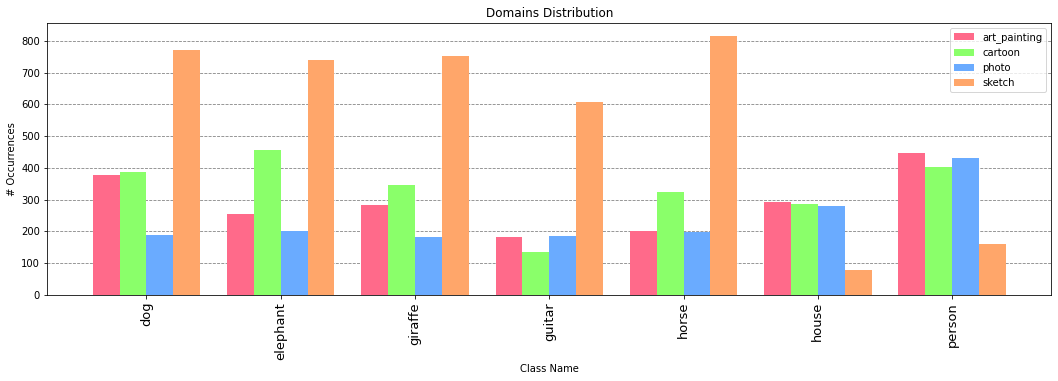

Stats for 'art_painting' domain
Total Images: 2048
Max # Images in a class: 7
Min # Images in a class: 448
Mean Images for classes: 183.00
STD Images for classes: 291.57

Stats for 'cartoon' domain
Total Images: 2344
Max # Images in a class: 7
Min # Images in a class: 456
Mean Images for classes: 134.00
STD Images for classes: 333.86

Stats for 'photo' domain
Total Images: 1670
Max # Images in a class: 7
Min # Images in a class: 431
Mean Images for classes: 181.00
STD Images for classes: 237.57

Stats for 'sketch' domain
Total Images: 3929
Max # Images in a class: 7
Min # Images in a class: 815
Mean Images for classes: 79.00
STD Images for classes: 560.29



In [7]:
#Show domains distributions
def getStatistics(values):
  values = list(values)
  count = len(values)
  maxv = max(values)
  minv = min(values)
  mean = np.mean(values)
  std = np.std(values)
  return [count,maxv,minv,mean,std]

domains = ['art_painting','cartoon','photo','sketch']#classes

datasets = [art_painting_dataset, cartoon_dataset, photo_dataset, sketch_dataset]

art_painting_size = {}
cartoon_size = {}
photo_size = {}
sketch_size = {}

elements = [0,0,0,0,0]
targets = train_dataset.classes + target_dataset.classes
class_to_idx = train_dataset.class_to_idx 
for d in datasets:
  for i in d.samples:
    elements[0] += 1
    ele_group = i[0]
    ele_class = i[1]

    
    class_name = next((name for name, index in class_to_idx.items() if index == ele_class), None)
    if(ele_group.find('art_painting')>0):
      elements[1] += 1
      if class_name not in art_painting_size:
        art_painting_size[class_name] = 0
      else:
        art_painting_size[class_name] = art_painting_size[class_name] + 1
    elif(ele_group.find('cartoon')>0):
      elements[2] += 1
      if class_name not in cartoon_size:
        cartoon_size[class_name] = 0
      else:
        cartoon_size[class_name] = cartoon_size[class_name] + 1
    elif(ele_group.find('photo')>0):
      elements[3] += 1
      if class_name not in photo_size:
        photo_size[class_name] = 0
      else:
        photo_size[class_name] = photo_size[class_name] + 1
    elif(ele_group.find('sketch')>0):
      elements[4] += 1
      if class_name not in sketch_size:
        sketch_size[class_name] = 0
      else:
        sketch_size[class_name] = sketch_size[class_name] + 1

    
fig, ax = plt.subplots(figsize=(18,5))
x_pos = np.arange(len(class_to_idx))
ax.set_xticks(x_pos)
ax.set_xticklabels(class_to_idx.keys(),rotation='vertical', fontsize=13)

colors = ['#ff6a8a','#8aff6a','#6aabff','#ffa66a']


width = 0.2
ax.bar(x_pos-width*3/2, art_painting_size.values(), width=width, color=colors[0])
ax.bar(x_pos-width/2, cartoon_size.values(), width=width, color=colors[1])
ax.bar(x_pos+width/2, photo_size.values(), width=width, color=colors[2])
ax.bar(x_pos+width*3/2, sketch_size.values(), width=width, color=colors[3])
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

stat = {}
stat[0] = getStatistics(art_painting_size.values())
stat[1] = getStatistics(cartoon_size.values())
stat[2] = getStatistics(photo_size.values())
stat[3] = getStatistics(sketch_size.values())

plt.title('Domains Distribution')
plt.xlabel('Class Name')
plt.ylabel('# Occurrences')
plt.legend(domains)
plt.show()

for i in range(len(stat)):
  print("Stats for '{}' domain".format(domains[i]))
  print('Total Images: {}'.format(elements[i+1]))
  print('Max # Images in a class: {}'.format(stat[i][0]) )
  print('Min # Images in a class: {}'.format(stat[i][1]) )
  print('Mean Images for classes: {:.2f}'.format(stat[i][2]) )
  print('STD Images for classes: {:.2f}'.format(stat[i][3]) )
  print()

**PREPARE NETWORK**

In [0]:
def NumParamsToTrain(net):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in net.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
  diff = total_params-total_trainable_params
  print(f'{diff:,} freezed parameters.')
  ratio = total_trainable_params/total_params
  print(f'{ratio:.4f} ratio training/total.')

In [0]:
import torch
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch.autograd import Function

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

#ctx.alpha must be optimized too
'''
ctx is a context object that can be
to stash information for backward computation. You can cache
objects for use in the backward pass using the ctx.save_for_backward method
'''

'''
'''
class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None



class AlexNet(nn.Module):

    def __init__(self, num_classes=1000, alpha=0.01):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

        self.alpha = nn.Parameter(torch.tensor(alpha))

    def forward(self, x, isAlpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # If we pass alpha, we can assume we are training the discriminator
        if isAlpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(x, self.alpha)
            discriminator_output = self.domain_classifier(reverse_feature)

            #v =  x.neg() * self.alpha
            #discriminator_output = self.domain_classifier(v)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            # do something else
            class_output = self.classifier(x)
            return class_output


    def setAlpha(self, alpha):
        self.alpha = nn.Parameter(torch.tensor(alpha))


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict,strict=False)
    return model


In [0]:

def InitializeNet(freeze=False, alpha=0.1):
  net = alexnet(True,alpha=alpha) # Loading AlexNet model

  if(freeze):
    for child in net.children():
      for param in child.parameters():
        param.requires_grad = False

  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                  # The convolutional layer is nn.Conv2d

  #Copy wights and biases of the classifier to the domain_classifier (The two FC layers must have the same weights and biases)
  count = 0
  #These are Dropouts and ReLus which do not have weights or biases
  skip = [0,2,3,5,7]
  for i in range(len(net.classifier)):
    if(count not in skip):
      net.domain_classifier[i].weight.data = net.classifier[i].weight.data
      net.domain_classifier[i].bias.data = net.classifier[i].bias.data
    count += 1

  NumParamsToTrain(net)
  return net

In [0]:
def PlotAccuracyLoss(loss, acc, meta=''):
  
  loss_gy = loss[0]
  if(len(loss)>1):
    loss_gd = loss[1]
    loss_gd_t = loss[2]
  
  acc_gy = acc[0]
  if(len(loss)>1):
    acc_gd = acc[1]
    acc_gd_t = acc[2]

  epoch = [i for i in range(len(loss_gy))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_gy = '#ff0000'
  color_gd = '#00a6ff'
  color_gd_t = '#51ff00'

  ax[0].plot(epoch,loss_gy,color=color_gy)
  ax[0].scatter(epoch,loss_gy,marker='s',s=size,color=color_gy)

  if(len(loss)>1):
    ax[0].plot(epoch,loss_gd,color=color_gd)
    ax[0].scatter(epoch,loss_gd,marker='s',s=size,color=color_gd)

    ax[0].plot(epoch,loss_gd_t,color=color_gd_t)
    ax[0].scatter(epoch,loss_gd_t,marker='s',s=size,color=color_gd_t)

  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  

  ax[1].plot(epoch,acc_gy,color=color_gy)
  ax[1].scatter(epoch,acc_gy,marker='s',s=size,color=color_gy)

  if(len(loss)>1):
    ax[1].plot(epoch,acc_gd,color=color_gd)
    ax[1].scatter(epoch,acc_gd,marker='s',s=size,color=color_gd)

    ax[1].plot(epoch,acc_gd_t,color=color_gd_t)
    ax[1].scatter(epoch,acc_gd_t,marker='s',s=size,color=color_gd_t)

  ax[1].set_title('Accurancy Graph')
  ax[1].set_ylabel('Accurancy')
  ax[1].set_xlabel('Epoch')
  
  fig.suptitle(meta)
  if(len(loss)>1):
    plt.legend(["Classifier",'Domain Classifier','Domain Classifier(Target)'])
  else:
    plt.legend(["Classifier"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  print('Classifier: Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gy),max(acc_gy) ))
  if(len(loss)>1):
    print('Domain Classifier: Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gd),max(acc_gd) ))
    print('Domain Classifier(Target): Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gd_t),max(acc_gd_t) ))

In [0]:
def SampleTarget(step,test_loader=target_dataloader):
  n_batches = len(test_loader.dataset)//BATCH_SIZE
  
  if step % n_batches == 0:
    target_set = iter(test_loader)
  return iter(test_loader).__next__()

In [0]:
PATH_MODELS = 'Models/'
if not os.path.isdir('./'+PATH_MODELS):
  os.mkdir('./'+PATH_MODELS)
def Training(net, adaptation=None, loader=train_dataloader, target_loader=target_dataloader, meta=''):
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  best_acc = -99

  current_step = 0
  losses_gy = []
  if(adaptation):
    losses_gd = []
    losses_gd_t = []

  accuracies_gy = []
  if(adaptation):
    accuracies_gd = []
    accuracies_gd_t = []

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects_gy = 0
    if(adaptation):
      running_corrects_gd = 0
      running_corrects_gd_t = 0

    # Iterate over the dataset
    for i, (images, labels) in enumerate(loader):
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)


      if(adaptation):
        target_images, _ = SampleTarget(current_step,target_loader)
        target_images = target_images.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      max_loss = 1000.0

      #####   STEP 1/3  #####
      #####   Forward to Gy and back propagate  #####
      # Forward pass to the network Gy
      outputs_gy = net(images)
      # Compute loss based on output and ground truth
      loss_gy = criterion(outputs_gy, labels)
      loss_gy.backward()  # backward pass: computes gradients
      loss_gy_value = loss_gy.item() if loss_gy.item() < max_loss else max_loss


      if(adaptation):
        #####   STEP 2/3  #####
        #####   Forward to Gd and back propagate  #####
        # Forward pass to the network Gd
        outputs_gd = net(images,ALPHA)
        #labels are 0 for all the data
        labels_gd = torch.tensor([0] * BATCH_SIZE)
        labels_gd = labels_gd.to(DEVICE)
        loss_gd = criterion(outputs_gd, labels_gd)
        loss_gd.backward()  # backward pass: computes
        loss_gd_value = loss_gd.item() if loss_gd.item() < max_loss else max_loss

        #####   STEP 3/3  #####
        #####   Forward to Gd and back propagate  #####
        # Forward pass to the network Gd
        outputs_gd_t = net(target_images,ALPHA)
        #labels are 1 for all the data
        labels_gd_t = torch.tensor([1] * BATCH_SIZE)#
        labels_gd_t = labels_gd_t.to(DEVICE)
        loss_gd_t = criterion(outputs_gd_t, labels_gd_t)
        loss_gd_t.backward()  # backward pass: computes
        loss_gd_t_value = loss_gd_t.item() if loss_gd_t.item() < max_loss else max_loss
      

      # Get predictions
      _, preds_gy = torch.max(outputs_gy.data, 1)

      if(adaptation):
        _, preds_gd = torch.max(outputs_gd.data, 1)
        _, preds_gd_t = torch.max(outputs_gd_t.data, 1)
        
      # Update Corrects
      running_corrects_gy += torch.sum(preds_gy == labels.data).data.item()
      if(adaptation):
        running_corrects_gd += torch.sum(preds_gd == labels_gd.data).data.item()
        running_corrects_gd_t += torch.sum(preds_gd_t == labels_gd_t.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        if(adaptation):
          print('Step {}, Loss Classifier: {:.4}, Domain Classifier: {:.4}, Domain Classifier(Target): {:.4}'.format(current_step, loss_gy_value, loss_gd, loss_gd_t))
        else:
          print('Step {}, Loss Classifier: {:.4}'.format(current_step, loss_gy_value))

      # Compute gradients for each layer and update weights
      
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

      # Step the scheduler
      #scheduler.step() 
    
    # Calculate Accuracy
    accuracy_gy = running_corrects_gy / float(len(loader.dataset))

    if(adaptation):
      accuracy_gd = running_corrects_gd / float(len(loader.dataset))
      accuracy_gd_t = running_corrects_gd_t / float(len(target_loader.dataset))

    if(accuracy_gy>best_acc):
      best_acc = accuracy_gy
      torch.save(net, PATH_MODELS+meta+'.pth')
      #best_model=net

    losses_gy.append(loss_gy_value)

    if(adaptation):
      losses_gd.append(loss_gd_value)
      losses_gd_t.append(loss_gd_t_value)

    accuracies_gy.append(accuracy_gy)

    if(adaptation):
      accuracies_gd.append(accuracy_gd)
      accuracies_gd_t.append(accuracy_gd_t)

    # Step the scheduler
    scheduler.step() 


  if(adaptation):
    losses = [losses_gy,losses_gd,losses_gd_t]
    accuracies = [accuracies_gy,accuracies_gd,accuracies_gd_t]
  else:
    losses = [losses_gy]
    accuracies = [accuracies_gy]
    
  return losses, accuracies

In [0]:
def Test(net,dataloader):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in (dataloader):#tqdm
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataloader.dataset))

  print('Test Accuracy: {}'.format(accuracy))

  return accuracy

In [0]:
def GetMaxAcc(scores):
  values = dict()
  for k,v in scores.items():
    values[k] = []
    acc = (0,0,0)

    a=np.array(v[1])
    if(len(a)==3):
      acc = ( np.max(a[0]), np.max(a[1]), np.max(a[2]) )
    else:
      acc = (np.max(a), -1, -1)
    values[k].append(acc)

  return values

def SketchHeatMap(score,performMax=True,training=True, Lr=True):
  if(performMax):
    score = GetMaxAcc(score)

  keys = list(score.keys())
  rows = sorted(set(i[0] for i in keys),reverse=True)
  cols = sorted(set(i[1] for i in keys))

  meta = 'Training' if training else 'Validation'

  if(performMax):
    values = []
    for v in list(score.values()):
      for i in v:
        values.append(i[0]) 
  else:
    values = list(score.values())

  v = np.reshape(values,(3,3))

  pd_scores = pd.DataFrame(v, index=rows, columns=cols)
  sns.heatmap(pd_scores, vmin=0, vmax=1, linewidths=.1, annot=True,xticklabels='auto', yticklabels='auto')
  plt.xlabel("Optimizer")
  if(Lr):
    plt.ylabel("Learning Rate")
  else:
    plt.ylabel("Alpha")
  plt.title('HeatMap {} Accuracy'.format(meta))
  plt.show()

# TRAINING WITHOUT ADAPTATION

111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.
Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.72
Starting epoch 2/30, LR = [0.001]
Step 10, Loss Classifier: 1.064
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss Classifier: 0.7883
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss Classifier: 0.8596
Starting epoch 7/30, LR = [0.001]
Step 40, Loss Classifier: 0.6829
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss Classifier: 0.817
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss Classifier: 0.7847
Starting epoch 12/30, LR = [0.001]
Step 70, Loss Classifier: 0.7357
Starting epoch 13/30, LR = [0.001]
Starting epoch 14/30, LR = [0.001]
Step 80, Loss Classifier: 0.6785
Starting epoch 15/30, LR = [0.001]
Starting epoch 16/30, LR = [0.001]
Step 90, Loss Classifier: 0.6994
Starting epoch 17/30, LR = [0.001]
Step 100, Loss Classifier: 0.7246
Starting epoch 18/30, LR = [0.001]
Starting epoch 19/30, LR = [0.001]
Step 110, Loss Clas

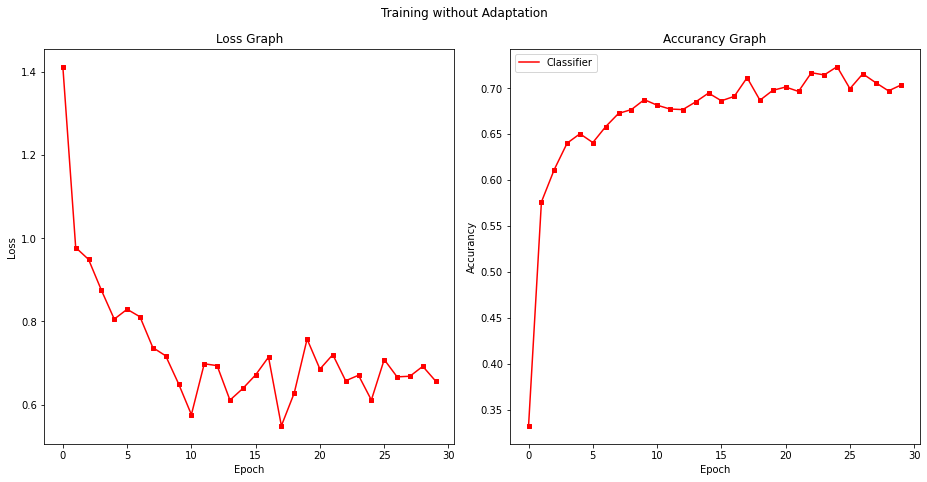

Classifier: Min Loss: 0.548740, Max Acc: 0.723353

Test Accuracy: 0.45556640625


In [0]:
net = InitializeNet()

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#Training on Photo dataset and testing on Art Painting dataset with no adaptation
meta_t = 'noAdap'
losses, accuracies = Training(net,meta=meta_t)

print()
meta = 'Training without Adaptation'
PlotAccuracyLoss(losses,accuracies,meta)

print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
_ = Test(best_net,target_dataloader)

# TRAINING WITH ADAPTATION

In [0]:
net = InitializeNet()

criterion = nn.CrossEntropyLoss()

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.


Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 3.069, Domain Classifier: 2.678, Domain Classifier(Target): 2.397
Starting epoch 2/30, LR = [0.001]
Step 10, Loss Classifier: 0.9199, Domain Classifier: 0.1156, Domain Classifier(Target): 0.07418
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss Classifier: 0.8999, Domain Classifier: 0.04459, Domain Classifier(Target): 0.04246
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss Classifier: 0.8639, Domain Classifier: 0.01476, Domain Classifier(Target): 0.04619
Starting epoch 7/30, LR = [0.001]
Step 40, Loss Classifier: 0.7613, Domain Classifier: 0.02306, Domain Classifier(Target): 0.03995
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss Classifier: 0.7761, Domain Classifier: 0.02249, Domain Classifier(Target): 0.03296
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss Classifier: 0.7466, Domain Classifier: 0.02379, Domain Classifier(Tar

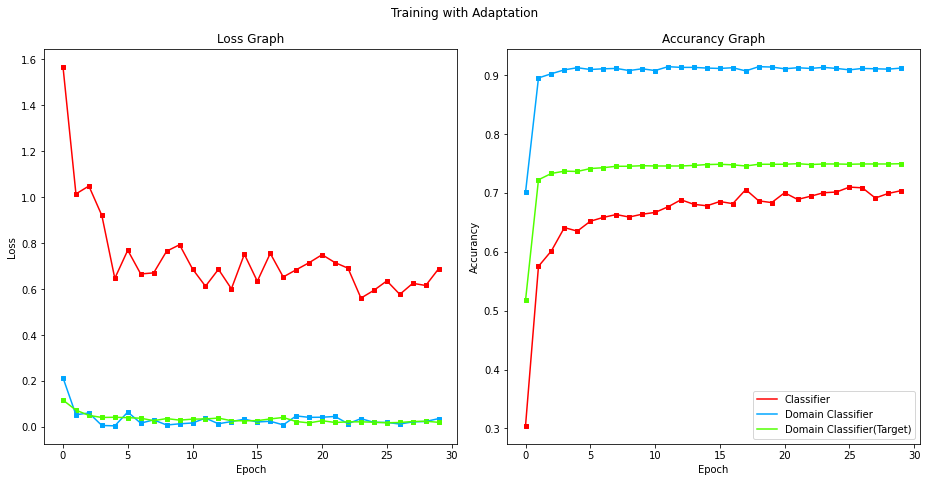

Classifier: Min Loss: 0.561185, Max Acc: 0.710180
Domain Classifier: Min Loss: 0.005207, Max Acc: 0.914970
Domain Classifier(Target): Min Loss: 0.018084, Max Acc: 0.750000

Test Accuracy: 0.443359375


In [0]:
#Training on Photo dataset and testing on Art Painting dataset with adaptation
meta_t = 'Adap'
losses, accuracies = Training(net,True,meta=meta_t)

print()
meta = 'Training with Adaptation'
PlotAccuracyLoss(losses,accuracies,meta)

print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
_ = Test(best_net,target_dataloader)

# HYPERPARAMETER OPTIMIZATION

NO ADAPTATION

---  Training with LR = 0.01 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.713
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 6.0
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 6.0
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 2.35
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 2.057
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 2.017
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 1.905
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 1.896
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, LR = [0.01]
Step 80, Loss Classifier: 1.877
Starting epoch 15/15, LR = [0.01]


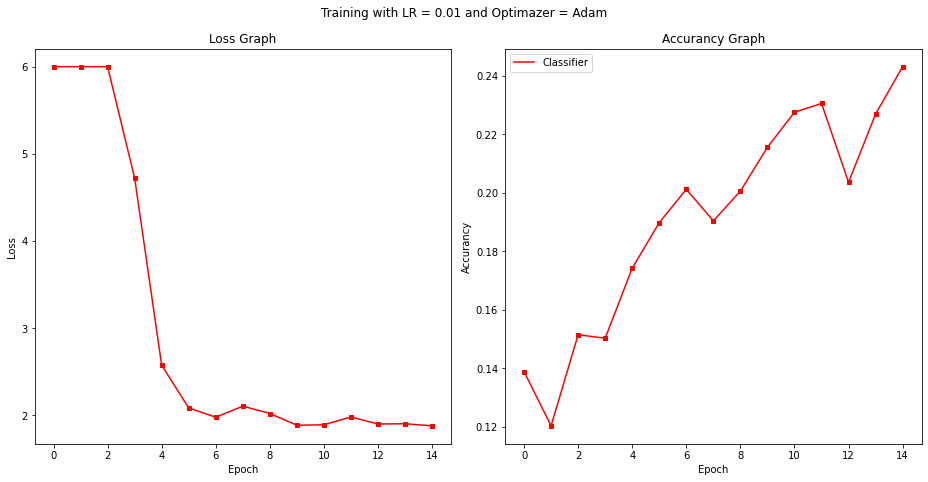

Classifier: Min Loss: 1.879988, Max Acc: 0.243114
****** Test ******
Test Accuracy: 0.11572265625
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.92
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 6.0
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 6.0
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 6.0
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 6.0
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 6.0
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 6.0
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 6.0
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, LR = [0.01]
Ste

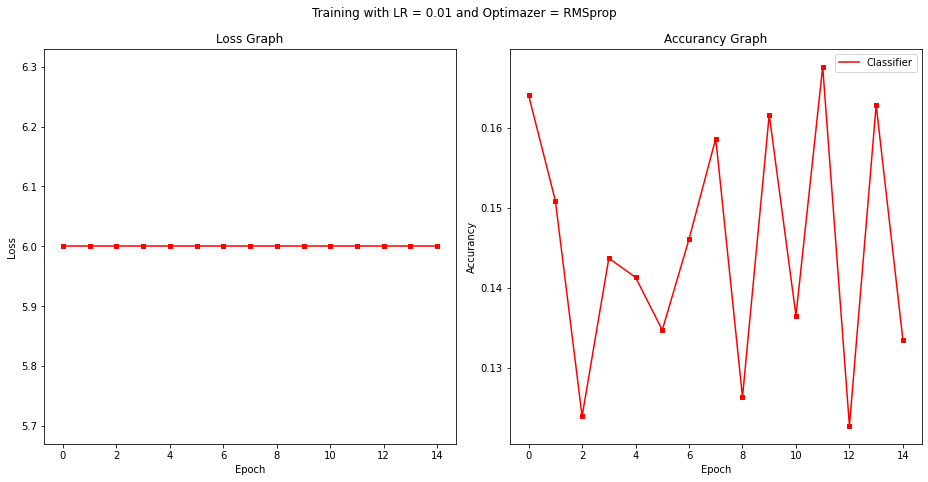

Classifier: Min Loss: 6.000000, Max Acc: 0.167665
****** Test ******
Test Accuracy: 0.14404296875
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.612
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1.013
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 0.8844
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 0.9027
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 0.7736
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 0.877
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 0.7912
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 0.667
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, 

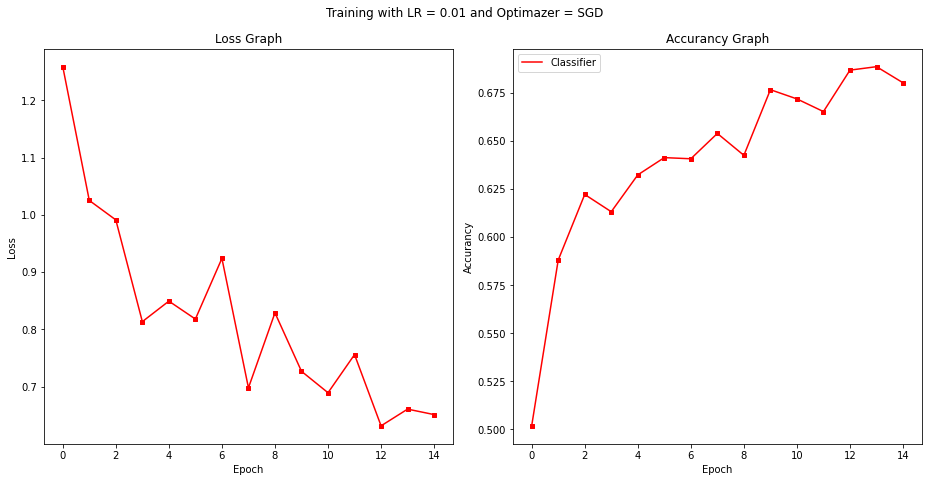

Classifier: Min Loss: 0.631432, Max Acc: 0.688623
****** Test ******
Test Accuracy: 0.42919921875
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.695
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.884
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.741
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.676
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.718
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.532
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 1.526
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 1.553
Starting epoch 13/15, LR = [0.001]
Starting ep

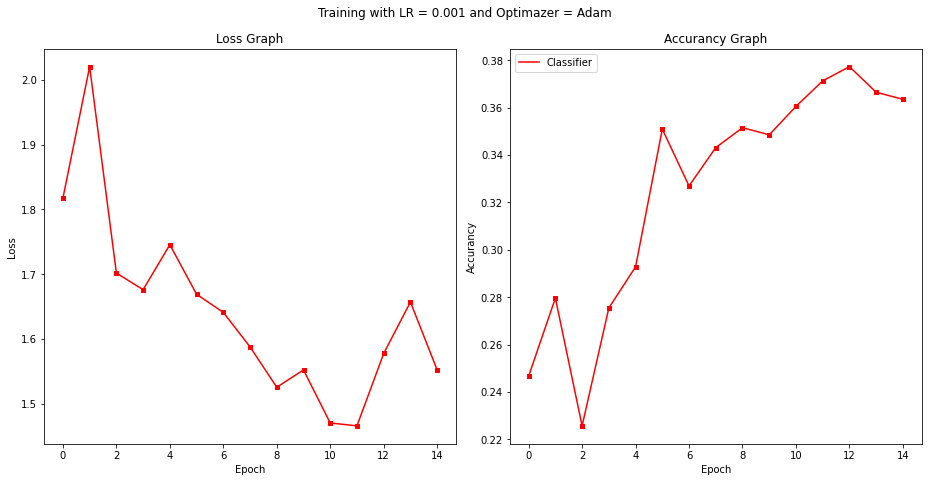

Classifier: Min Loss: 1.466197, Max Acc: 0.377246
****** Test ******
Test Accuracy: 0.15380859375
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.865
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 6.0
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 6.0
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 2.432
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 6.0
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 3.085
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 6.0
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 6.0
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/

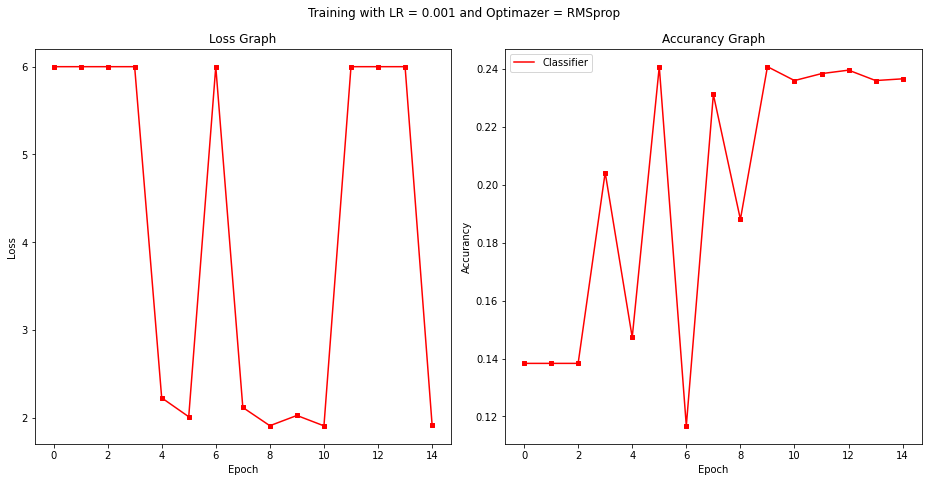

Classifier: Min Loss: 1.908756, Max Acc: 0.240719
****** Test ******
Test Accuracy: 0.125
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.395
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 0.9367
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.8625
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.9181
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 0.7455
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 0.8889
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 0.6041
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 0.7474
Starting epoch 13/15, LR = [0.001]
Starting epoc

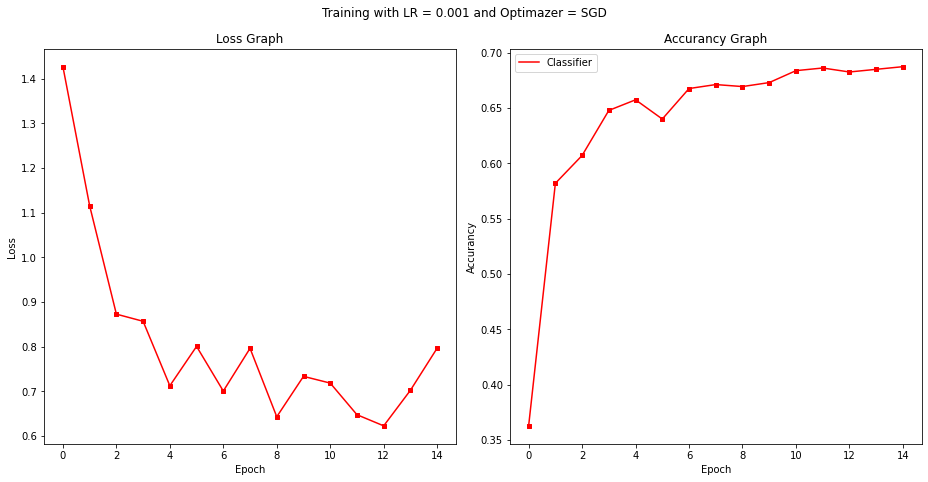

Classifier: Min Loss: 0.622822, Max Acc: 0.687425
****** Test ******
Test Accuracy: 0.45263671875
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.874
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 1.948
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 1.542
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 1.288
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.131
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 1.08
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 1.082
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 1.041
Starting epoch 13/15, LR = [1e-05]
Starting epo

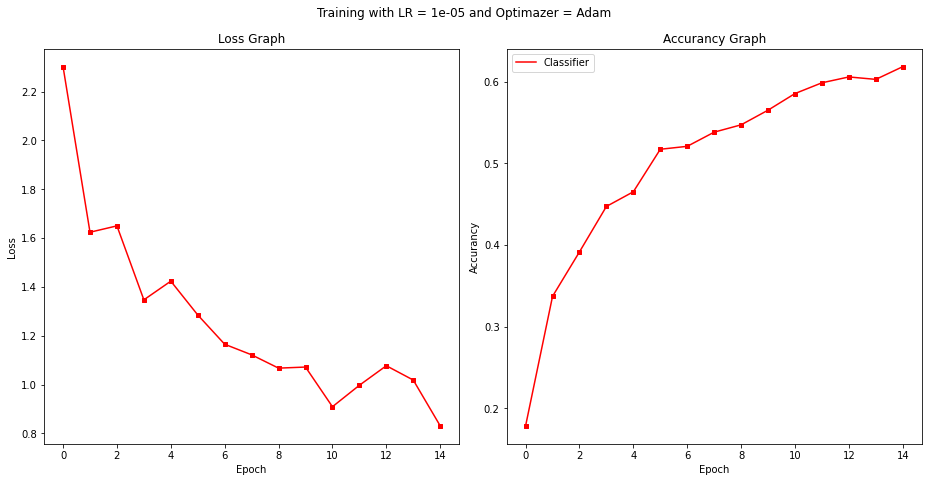

Classifier: Min Loss: 0.831018, Max Acc: 0.618563
****** Test ******
Test Accuracy: 0.37841796875
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.778
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 0.9972
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 0.8737
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 0.6729
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 0.7926
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 0.675
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 0.7006
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 0.6804
Starting epoch 13/15, LR = [1e-05]
St

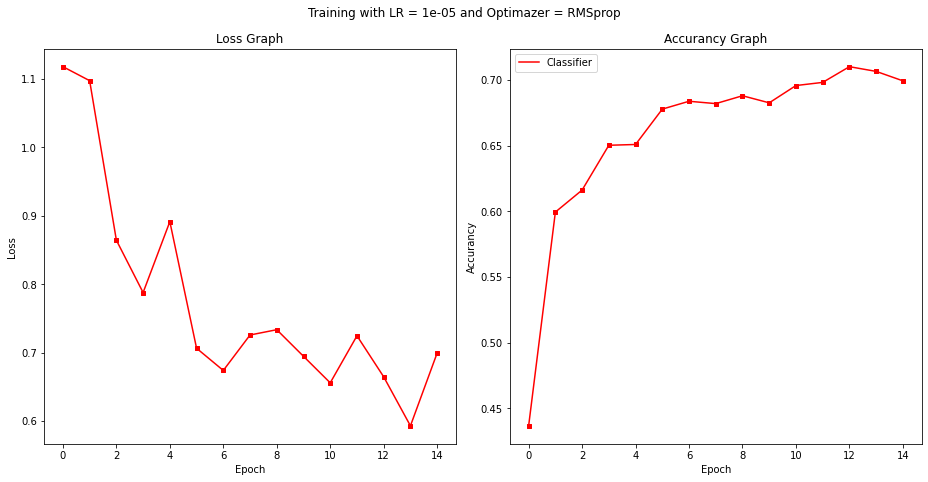

Classifier: Min Loss: 0.592921, Max Acc: 0.710180
****** Test ******
Test Accuracy: 0.427734375
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.847
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 2.615
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 2.392
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 1.926
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.879
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 1.755
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 1.55
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 1.587
Starting epoch 13/15, LR = [1e-05]
Starting epoch 

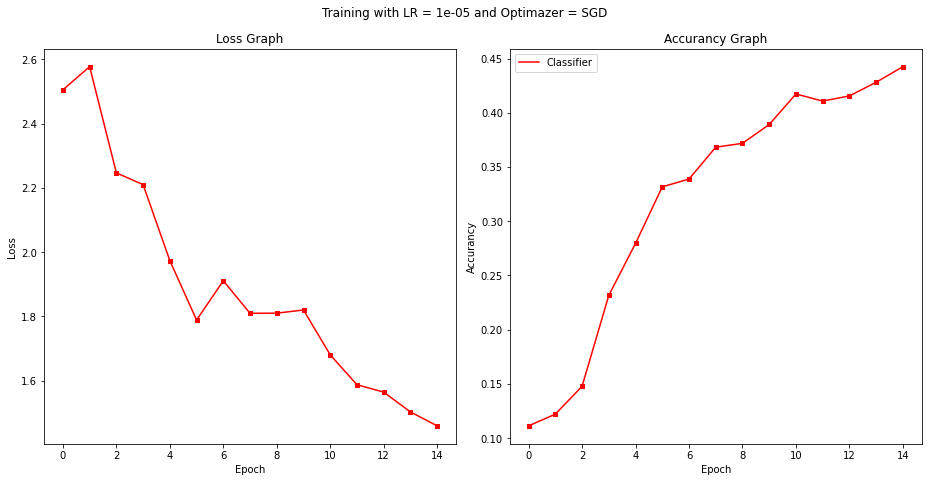

Classifier: Min Loss: 1.459282, Max Acc: 0.442515
****** Test ******
Test Accuracy: 0.27001953125
---  --- ---  ---



In [0]:
NUM_EPOCHS = 15
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

scores_noAdap = {}
for lr in lr_values:
  for op in optimazers:

    meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
    print('---  {}  ---'.format(meta))

    net = InitializeNet()
    print()

    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    meta_t = 'noAdap LR={}, op={}'.format(lr,op)
    losses, accuracies = Training(net,meta=meta_t)
    PlotAccuracyLoss(losses,accuracies,meta)

    print('****** Test ******')
    #acc_test = Test(net,target_dataloader)

    scores_noAdap[(lr,op)] = (losses, accuracies)

    print('---  --- ---  ---')
    print()


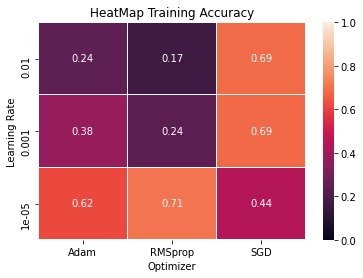

In [0]:
SketchHeatMap(scores_noAdap)

In [0]:
meta_t = 'noAdap LR={}, op={}'.format(0.00001,'Adam')
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
Test(best_net, target_dataloader)

noAdap LR=0.01, op=Adam
Test Accuracy: 0.11572265625
noAdap LR=0.01, op=RMSprop
Test Accuracy: 0.09814453125
noAdap LR=0.01, op=SGD
Test Accuracy: 0.39794921875
noAdap LR=0.001, op=Adam
Test Accuracy: 0.15869140625
noAdap LR=0.001, op=RMSprop
Test Accuracy: 0.13916015625
noAdap LR=0.001, op=SGD
Test Accuracy: 0.45263671875
noAdap LR=1e-05, op=Adam
Test Accuracy: 0.37841796875
noAdap LR=1e-05, op=RMSprop
Test Accuracy: 0.4287109375
noAdap LR=1e-05, op=SGD
Test Accuracy: 0.27001953125


ADAPTATION

---  Training with Alpha = 0.5 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.61, Domain Classifier: 3.203, Domain Classifier(Target): 2.072
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 4.169, Domain Classifier: 0.002292, Domain Classifier(Target): 235.5
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 3.623, Domain Classifier: 0.0003558, Domain Classifier(Target): 309.8
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 6.328, Domain Classifier: 12.86, Domain Classifier(Target): 137.9
Starting epoch 7/10, LR = [0.001]
Step 40, Loss Classifier: 10.21, Domain Classifier: 21.97, Domain Classifier(Target): 142.8
Starting epoch 8/10, LR = [0.001]
Starting epoch 9/10, LR = [0.001]
Step 50, Loss Classifier: 52.4, Domain Classifier: 13.94, Domain Classifier(Target): 30.77
Starting epoch 10/10, LR = [0.001]


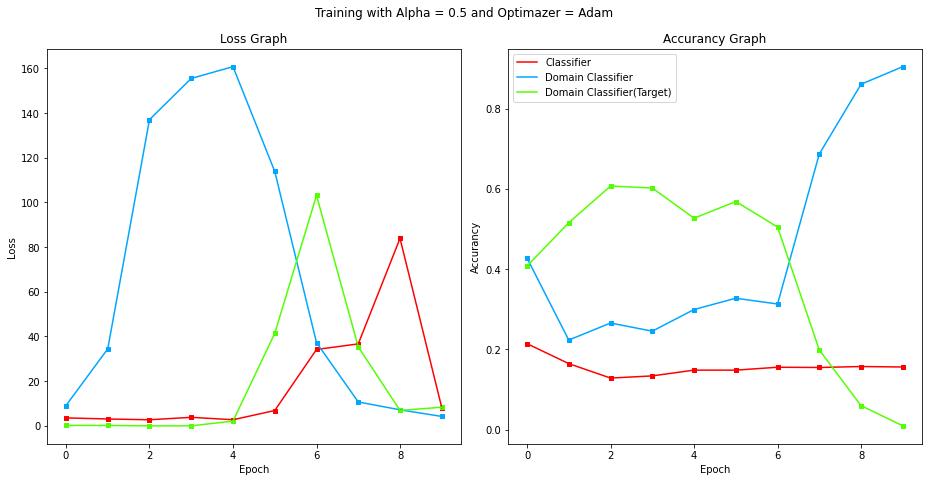

Classifier: Min Loss: 2.725724, Max Acc: 0.214371
Domain Classifier: Min Loss: 4.209986, Max Acc: 0.904192
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.606934
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.5 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.422, Domain Classifier: 2.625, Domain Classifier(Target): 1.653
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1e+04, Domain Classifier: 5.317e+08, Domain Classifier(Target): 9.21e+08
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 4.038, Domain Classifier: 9.316e+13, Domain Classifier(Target): 0.0
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 4.025, Domain Classifier: 6.027e+14, Domain Classifier(Target): 4.671e+13
Starting epoch 7/10, LR = [

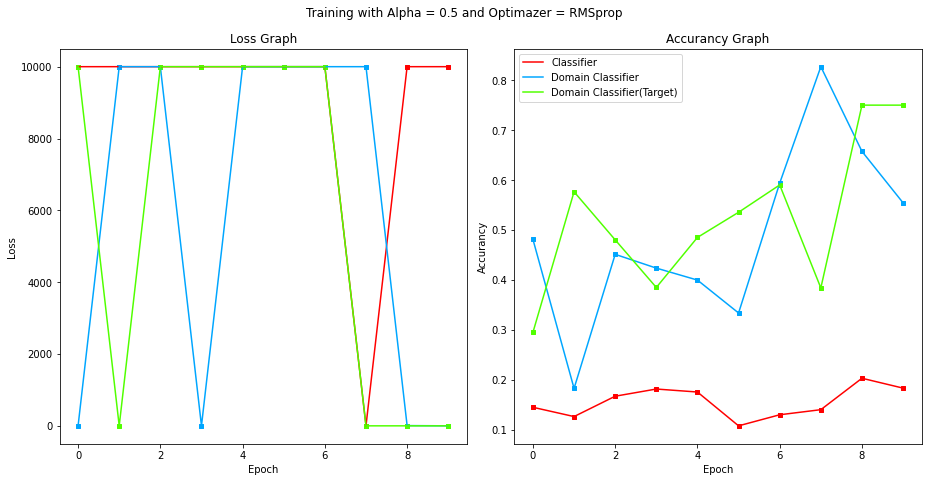

Classifier: Min Loss: 2.544327, Max Acc: 0.203593
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.826946
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.750000
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.5 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.803, Domain Classifier: 3.927, Domain Classifier(Target): 1.924
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1.113, Domain Classifier: 0.03533, Domain Classifier(Target): 0.1104
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 0.8736, Domain Classifier: 0.07147, Domain Classifier(Target): 0.3558
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 0.9183, Domain Classifier: 0.9103, Domain Classifier(Target): 0.03828
Starting epoch 7/10, LR = [0.001]
Ste

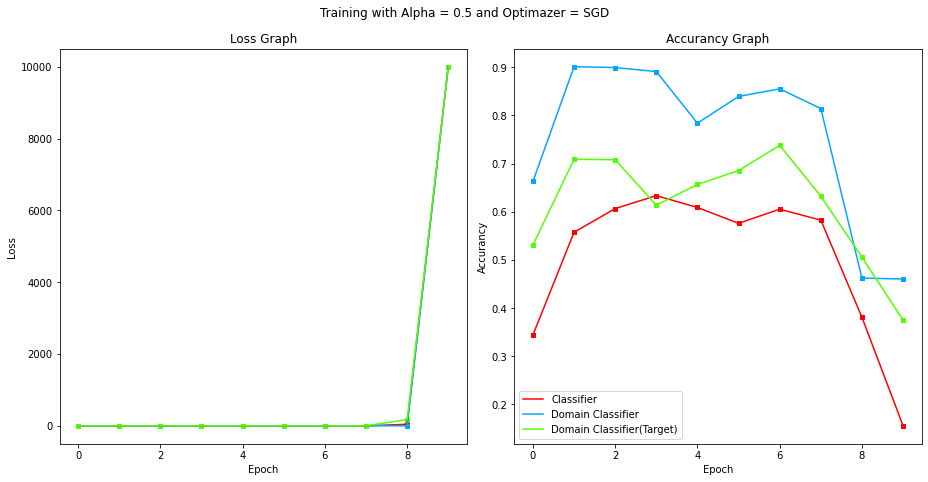

Classifier: Min Loss: 0.942153, Max Acc: 0.633533
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.901198
Domain Classifier(Target): Min Loss: 0.003361, Max Acc: 0.737793
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.646, Domain Classifier: 1.609, Domain Classifier(Target): 2.564
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 4.058, Domain Classifier: 0.5797, Domain Classifier(Target): 16.61
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 2.718, Domain Classifier: 4.082, Domain Classifier(Target): 0.6901
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 2.188, Domain Classifier: 2.191, Domain Classifier(Target): 0.004456
Starting epoch 7/10, LR = [0.001]
Step 40,

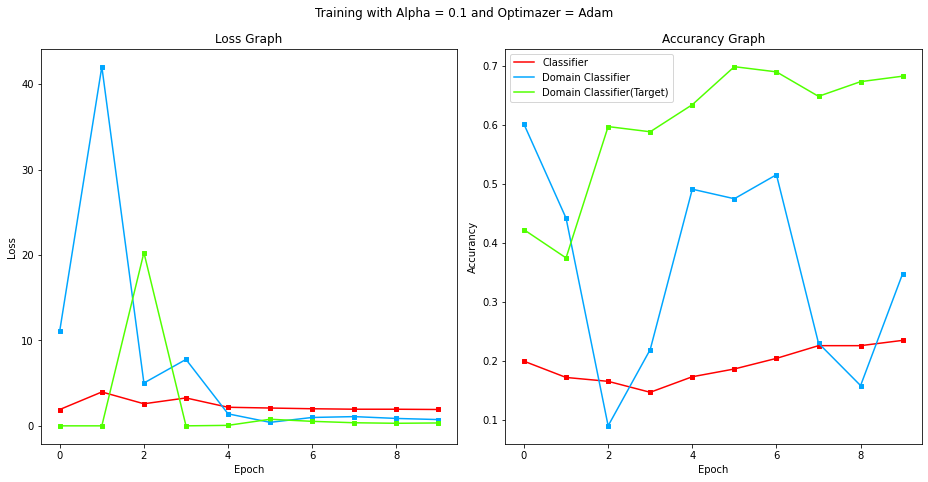

Classifier: Min Loss: 1.910760, Max Acc: 0.234731
Domain Classifier: Min Loss: 0.410038, Max Acc: 0.601198
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.698730
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.813, Domain Classifier: 2.305, Domain Classifier(Target): 1.844
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1e+04, Domain Classifier: 0.0, Domain Classifier(Target): 1.785e+07
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 3.147, Domain Classifier: 0.0, Domain Classifier(Target): 1.634e+04
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 915.4, Domain Classifier: 2.026e+06, Domain Classifier(Target): 0.0
Starting epoch 7/10, LR = [0.001]
Step

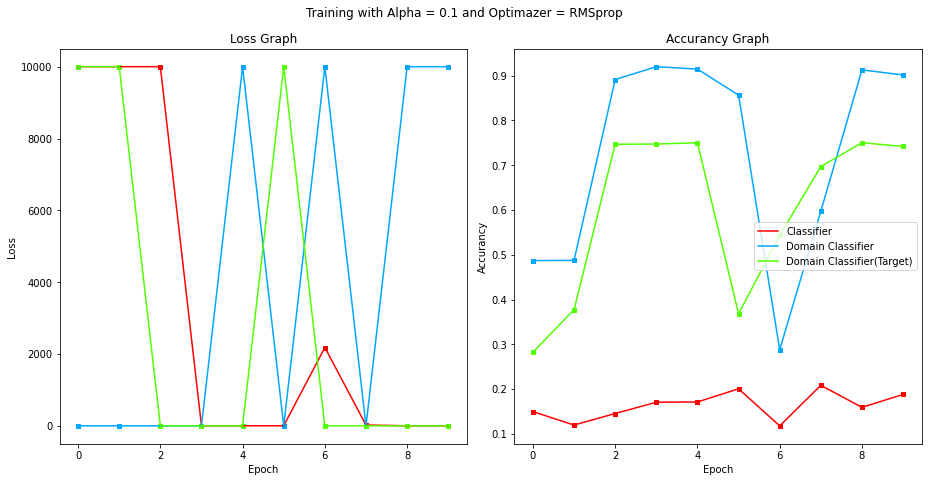

Classifier: Min Loss: 2.078282, Max Acc: 0.208383
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.750000
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.951, Domain Classifier: 2.93, Domain Classifier(Target): 2.044
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1.045, Domain Classifier: 0.2058, Domain Classifier(Target): 0.05433
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 1.015, Domain Classifier: 0.0192, Domain Classifier(Target): 0.06004
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 0.7264, Domain Classifier: 0.03352, Domain Classifier(Target): 0.0592
Starting epoch 7/10, LR = [0.001]
Step 

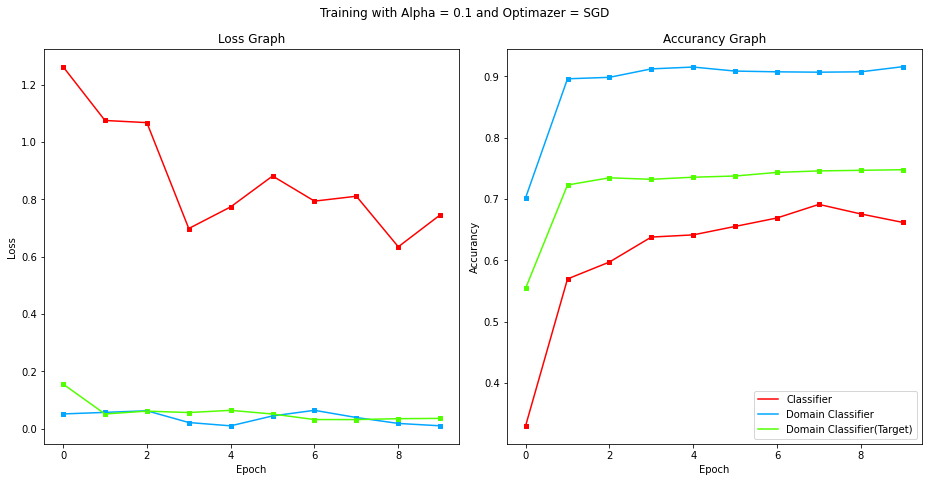

Classifier: Min Loss: 0.634459, Max Acc: 0.691018
Domain Classifier: Min Loss: 0.009410, Max Acc: 0.915569
Domain Classifier(Target): Min Loss: 0.031306, Max Acc: 0.747559
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 3.183, Domain Classifier: 2.358, Domain Classifier(Target): 2.578
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1.56, Domain Classifier: 0.7902, Domain Classifier(Target): 0.673
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 1.336, Domain Classifier: 0.04642, Domain Classifier(Target): 0.08429
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 1.369, Domain Classifier: 0.1612, Domain Classifier(Target): 0.1624
Starting epoch 7/10, LR = [0.001]
Step 4

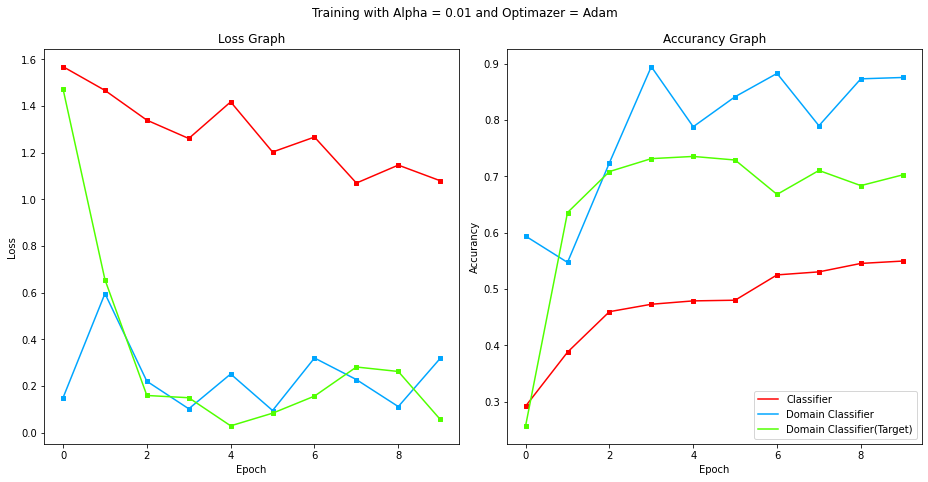

Classifier: Min Loss: 1.069177, Max Acc: 0.549701
Domain Classifier: Min Loss: 0.094769, Max Acc: 0.894611
Domain Classifier(Target): Min Loss: 0.029071, Max Acc: 0.735352
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.543, Domain Classifier: 2.264, Domain Classifier(Target): 2.611
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1e+04, Domain Classifier: 2.494e+04, Domain Classifier(Target): 0.0
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 1e+04, Domain Classifier: 1.339e+05, Domain Classifier(Target): 0.0
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 788.1, Domain Classifier: 976.1, Domain Classifier(Target): 0.0
Starting epoch 7/10, LR = [0.001]
Step 40

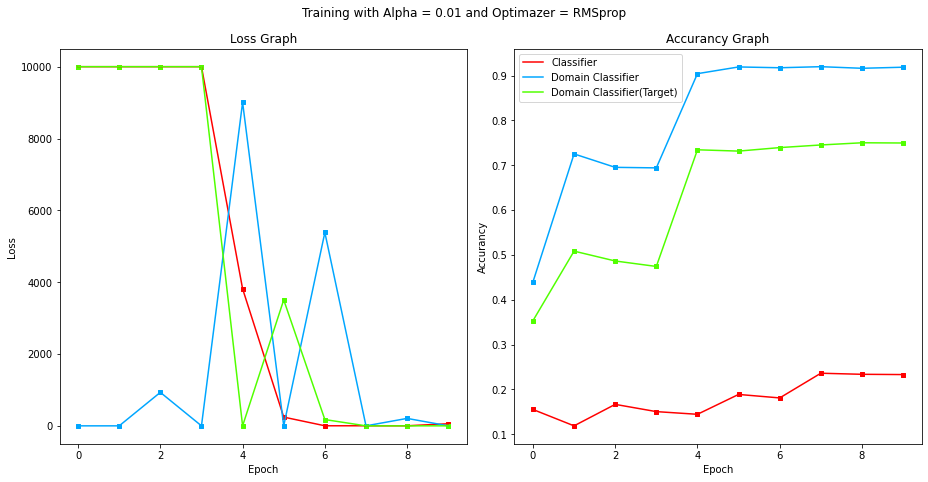

Classifier: Min Loss: 1.906114, Max Acc: 0.235928
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.750000
****** Test ******
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/10, LR = [0.001]
Step 0, Loss Classifier: 2.542, Domain Classifier: 3.334, Domain Classifier(Target): 2.348
Starting epoch 2/10, LR = [0.001]
Step 10, Loss Classifier: 1.04, Domain Classifier: 0.02002, Domain Classifier(Target): 0.06847
Starting epoch 3/10, LR = [0.001]
Starting epoch 4/10, LR = [0.001]
Step 20, Loss Classifier: 0.9807, Domain Classifier: 0.01082, Domain Classifier(Target): 0.03843
Starting epoch 5/10, LR = [0.001]
Starting epoch 6/10, LR = [0.001]
Step 30, Loss Classifier: 0.7043, Domain Classifier: 0.03433, Domain Classifier(Target): 0.02512
Starting epoch 7/10, LR = [0.001]


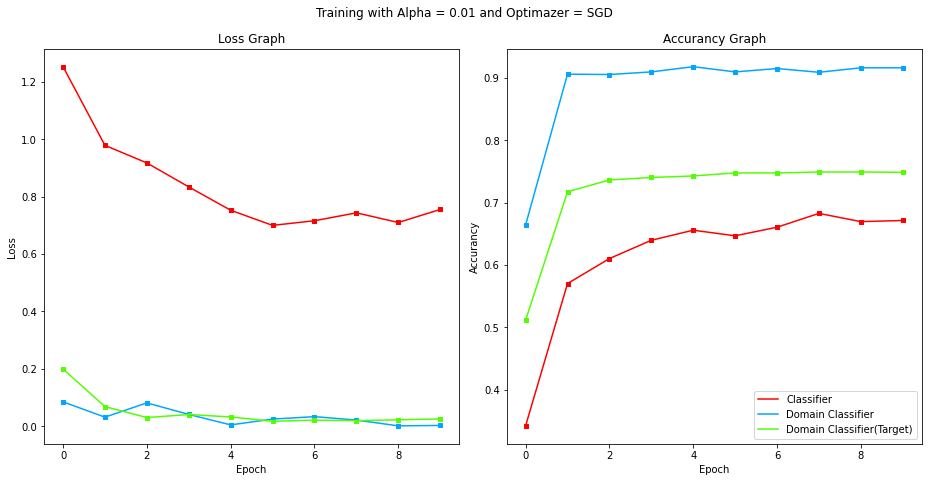

Classifier: Min Loss: 0.699667, Max Acc: 0.682635
Domain Classifier: Min Loss: 0.001201, Max Acc: 0.917964
Domain Classifier(Target): Min Loss: 0.017113, Max Acc: 0.749023
****** Test ******
---  --- ---  ---



In [0]:
NUM_EPOCHS = 10
alpha_values = [0.5, 0.1, 0.01]
optimazers = ['Adam','RMSprop','SGD']

scores_Adap = {}
for al in alpha_values:
  for op in optimazers:

    meta = 'Training with Alpha = {} and Optimazer = {}'.format(al,op)
    print('---  {}  ---'.format(meta))

    net = InitializeNet(alpha=al)
    print()

    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    meta_t = 'Adap al={}, op={}'.format(al,op)
    losses, accuracies = Training(net,True,meta=meta_t)
    PlotAccuracyLoss(losses,accuracies,meta)

    scores_Adap[(al,op)] = (losses, accuracies)

    print('****** Test ******')
    #_ = Test(net,target_dataloader)

    print('---  --- ---  ---')
    print()


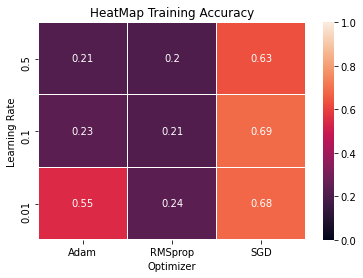

In [0]:
SketchHeatMap(scores_Adap)

In [0]:
for al in alpha_values:
  for op in optimazers:
    meta_t = 'Adap al={}, op={}'.format(al,op)
    print(meta_t)
    best_net = torch.load(PATH_MODELS+meta_t+'.pth')
    Test(best_net, target_dataloader)

Adap al=0.5, op=Adam
Test Accuracy: 0.10986328125
Adap al=0.5, op=RMSprop
Test Accuracy: 0.21923828125
Adap al=0.5, op=SGD
Test Accuracy: 0.36328125
Adap al=0.1, op=Adam
Test Accuracy: 0.21923828125
Adap al=0.1, op=RMSprop
Test Accuracy: 0.18505859375
Adap al=0.1, op=SGD
Test Accuracy: 0.451171875
Adap al=0.01, op=Adam
Test Accuracy: 0.23193359375
Adap al=0.01, op=RMSprop
Test Accuracy: 0.2138671875
Adap al=0.01, op=SGD
Test Accuracy: 0.47412109375


# EXTRA

## No Adaptation

---  Training with LR = 0.01 and Optimazer = Adam, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.328
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 308.8
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 3.039
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 45.25
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 1.989
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 1.889
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 3.314
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, LR = [0.01]
Step 80, Loss Classifier: 1.941
Starting epoch 15/15, LR = [0.01]


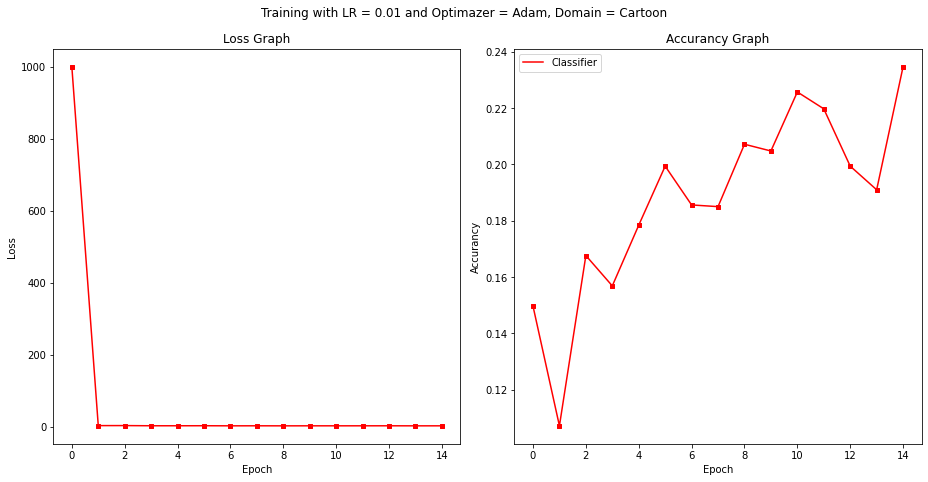

Classifier: Min Loss: 1.869952, Max Acc: 0.234731
****** Test ******
Test Accuracy: 0.17320819112627986
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = Adam, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.592
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 72.53
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 15.33
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 5.043
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 1.956
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 2.023
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 1.927
Starting epoch 13/15, LR = [0.01]
St

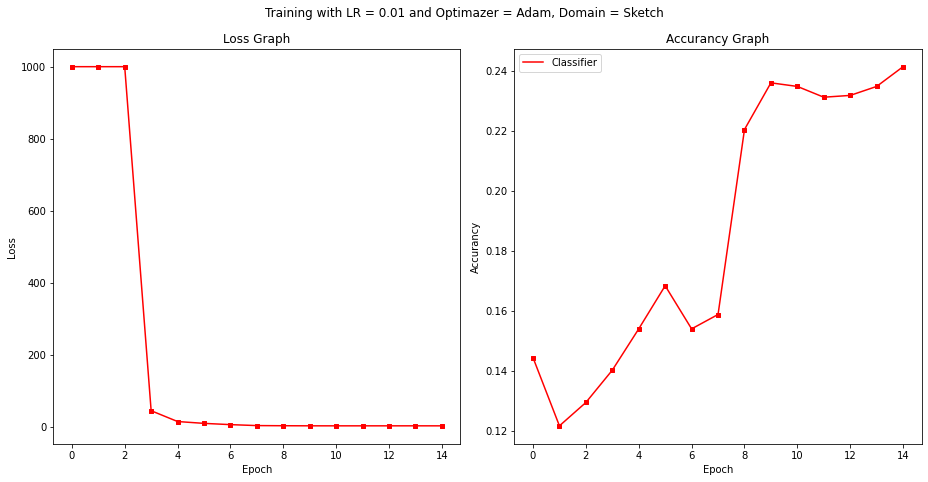

Classifier: Min Loss: 1.882237, Max Acc: 0.241317
****** Test ******
Test Accuracy: 0.021634003563247645
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.837
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 1e+03
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 1e+03
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 1e+03
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 1e+03
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 1e+03
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 1e+03
Starting epoch 13/15, LR = [0.0

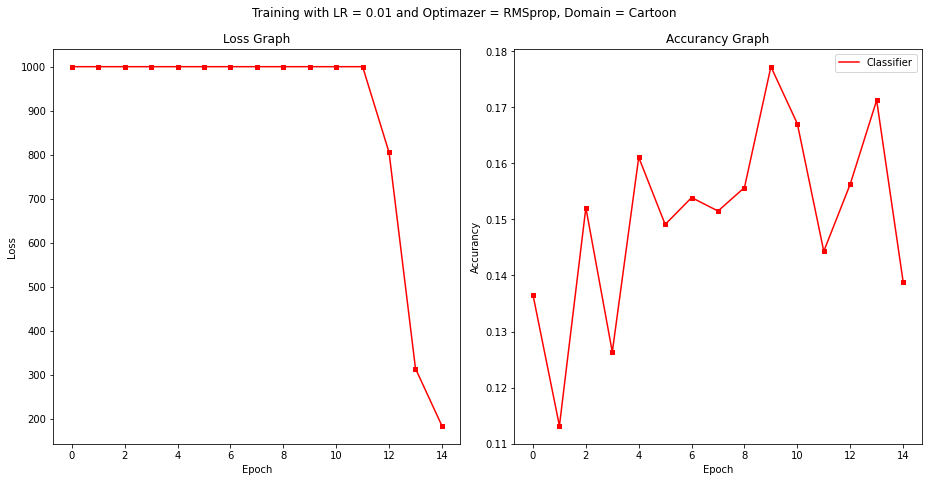

Classifier: Min Loss: 184.390274, Max Acc: 0.177246
****** Test ******
Test Accuracy: 0.19411262798634812
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.53
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 1e+03
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 1e+03
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 1e+03
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 1e+03
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 1e+03
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 1e+03
Starting epoch 13/15, LR = [0.01

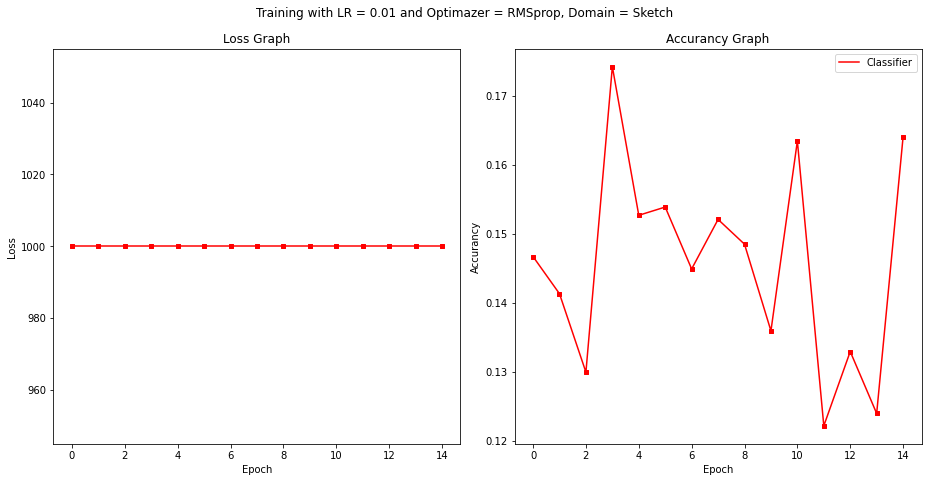

Classifier: Min Loss: 1000.000000, Max Acc: 0.174251
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.76
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1.088
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 1.038
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 0.8009
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 0.8843
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 0.8299
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 0.745
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 0.6776
Starting epoch 13/15, LR = [0.

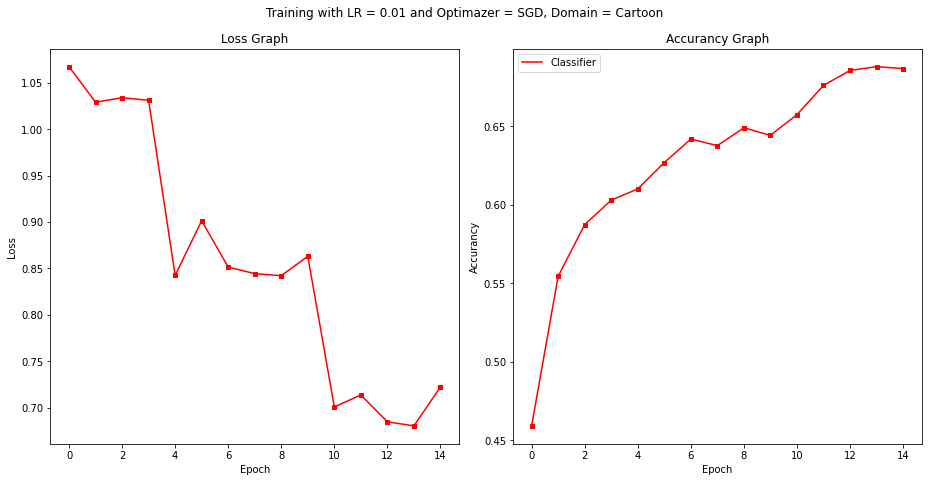

Classifier: Min Loss: 0.680351, Max Acc: 0.688024
****** Test ******
Test Accuracy: 0.22994880546075086
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.01]
Step 0, Loss Classifier: 2.768
Starting epoch 2/15, LR = [0.01]
Step 10, Loss Classifier: 1.327
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Step 20, Loss Classifier: 0.9222
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Step 30, Loss Classifier: 0.8729
Starting epoch 7/15, LR = [0.01]
Step 40, Loss Classifier: 0.7429
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Step 50, Loss Classifier: 0.8544
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Step 60, Loss Classifier: 0.6705
Starting epoch 12/15, LR = [0.01]
Step 70, Loss Classifier: 0.8668
Starting epoch 13/15, LR = [0.0

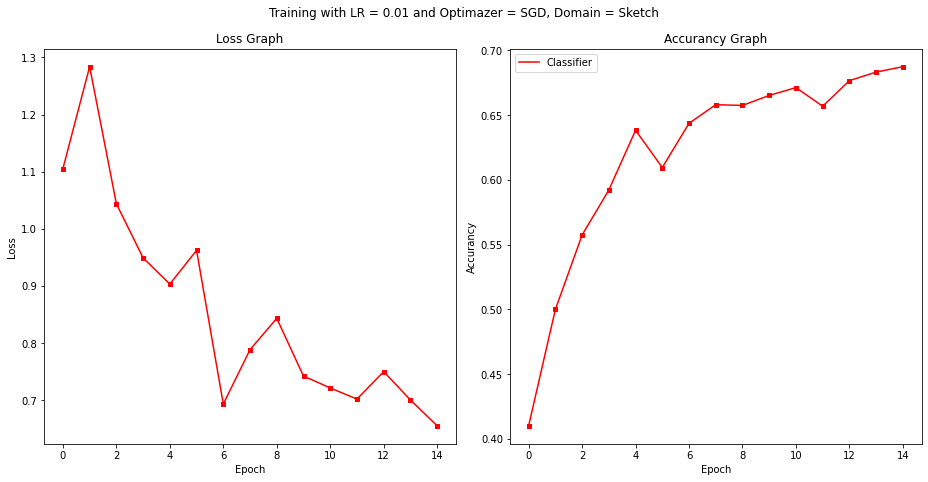

Classifier: Min Loss: 0.655471, Max Acc: 0.687425
****** Test ******
Test Accuracy: 0.24713667599898193
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.737
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.953
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 2.005
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.894
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.916
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.907
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 1.89
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 1.899
Starting epoch 13/15, L

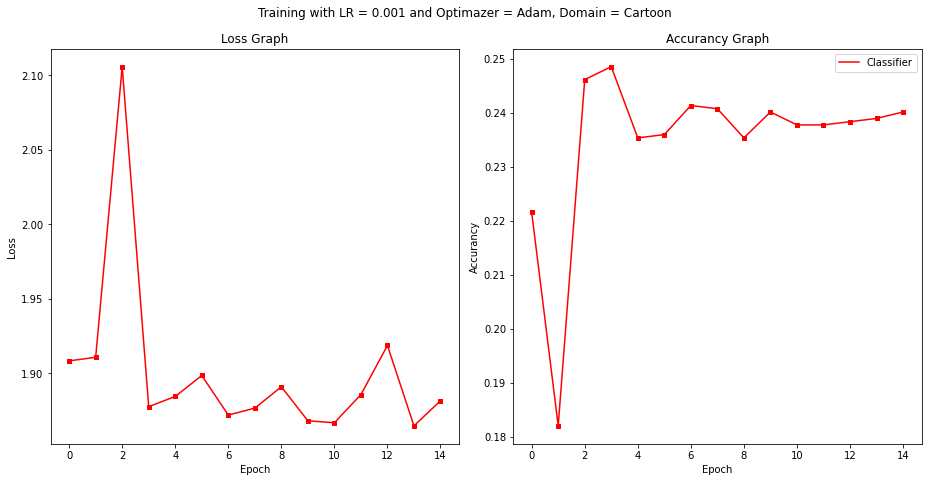

Classifier: Min Loss: 1.864756, Max Acc: 0.248503
****** Test ******
Test Accuracy: 0.1727815699658703
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.588
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.842
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.803
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.878
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.867
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.913
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 1.899
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 1.908
Starting epoch 13/15, LR

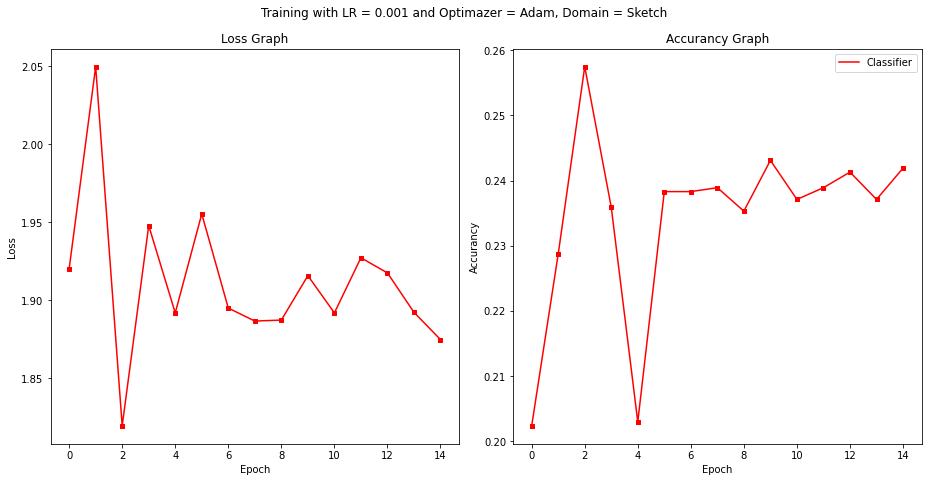

Classifier: Min Loss: 1.819391, Max Acc: 0.257485
****** Test ******
Test Accuracy: 0.020361415118350726
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.588
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 27.3
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 638.7
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.927
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.911
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 1.91
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 1.935
Starting epoch 13/15

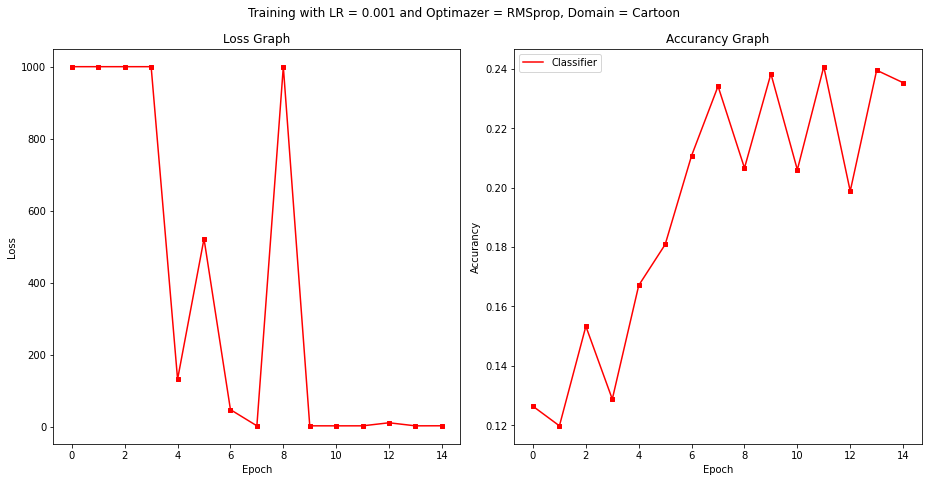

Classifier: Min Loss: 1.869903, Max Acc: 0.240719
****** Test ******
Test Accuracy: 0.1727815699658703
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.79
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 3.009
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.97
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.886
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 2.625
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 1.862
Starting epoch 13/15, L

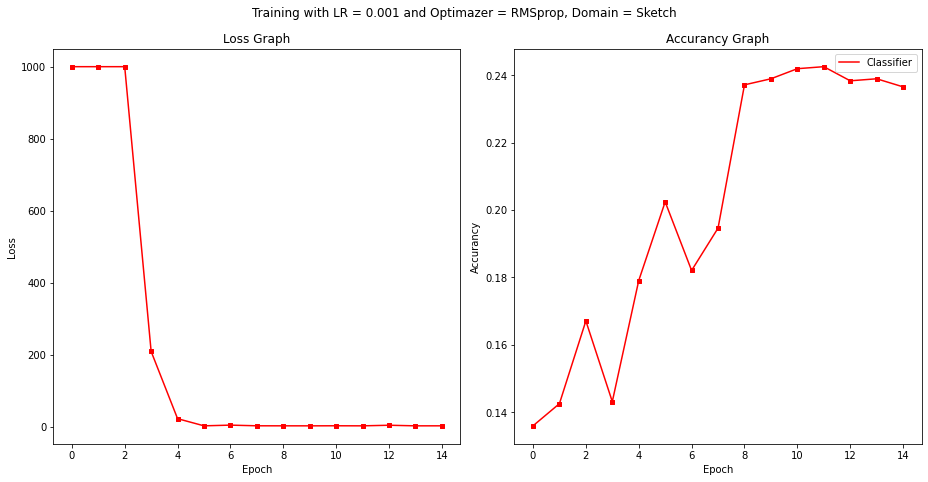

Classifier: Min Loss: 1.890429, Max Acc: 0.242515
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.749
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 0.8456
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9948
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.7127
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 0.7135
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 0.8413
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 0.7082
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 0.7433
Starting epoch 1

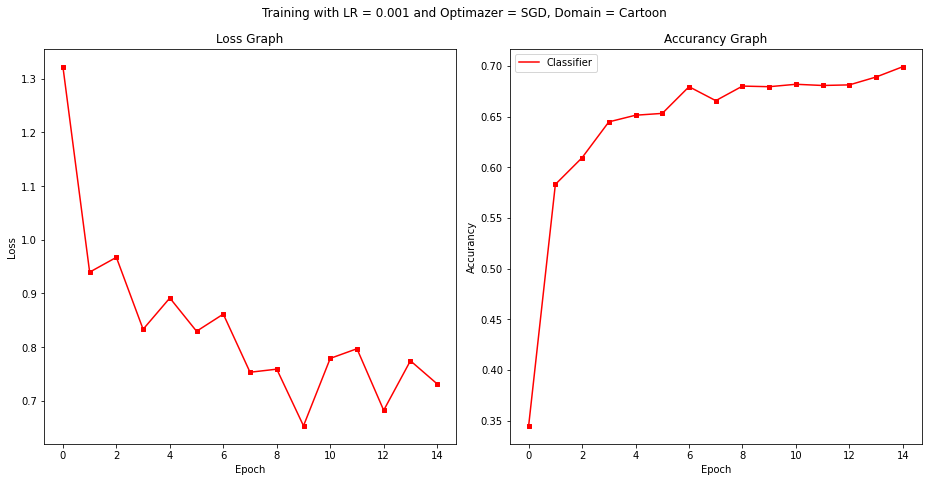

Classifier: Min Loss: 0.653354, Max Acc: 0.699401
****** Test ******
Test Accuracy: 0.1719283276450512
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.76
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.09
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.8973
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.681
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 0.7568
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 0.7666
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 0.6891
Starting epoch 12/15, LR = [0.001]
Step 70, Loss Classifier: 0.6892
Starting epoch 13/15, 

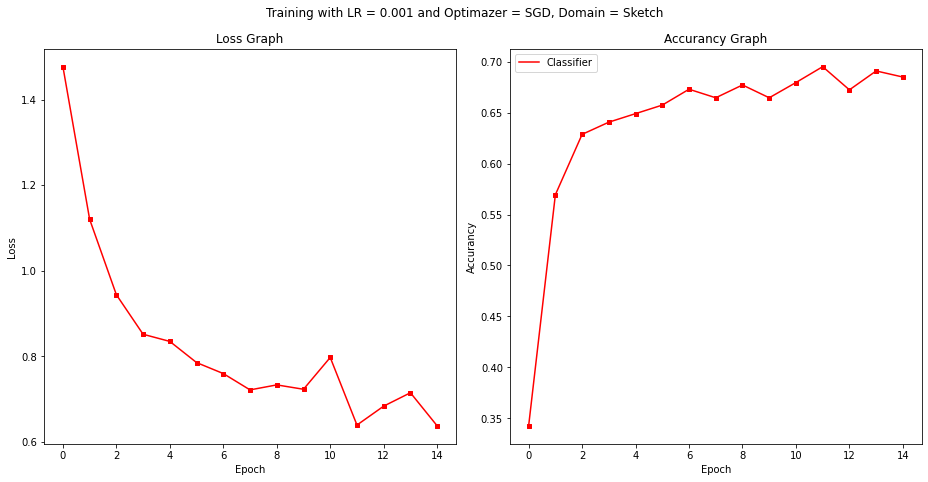

Classifier: Min Loss: 0.637290, Max Acc: 0.695210
****** Test ******
Test Accuracy: 0.1616187325019089
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.583
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 1.829
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 1.551
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 1.243
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.192
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 1.094
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 0.9438
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 1.018
Starting epoch 13/15, 

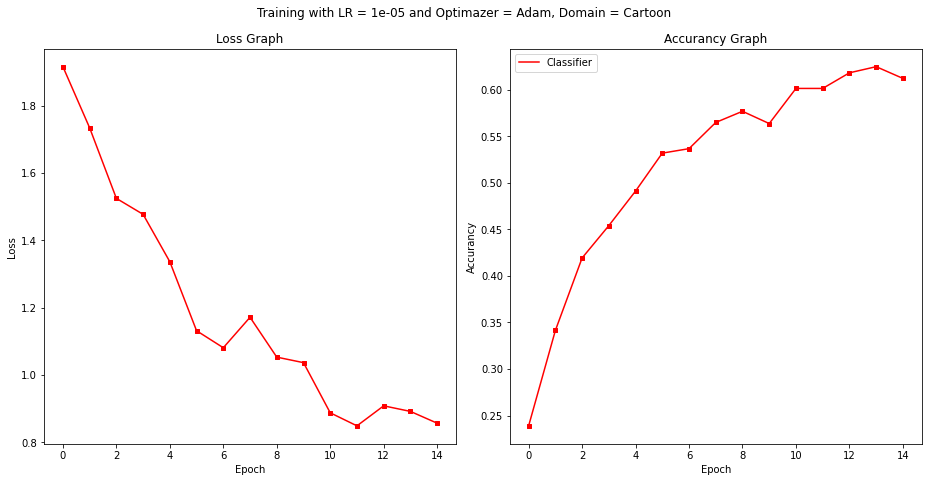

Classifier: Min Loss: 0.848659, Max Acc: 0.624551
****** Test ******
Test Accuracy: 0.181740614334471
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 3.034
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 1.893
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 1.619
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 1.308
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.014
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 0.9764
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 0.9887
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 0.9865
Starting epoch 13/15, 

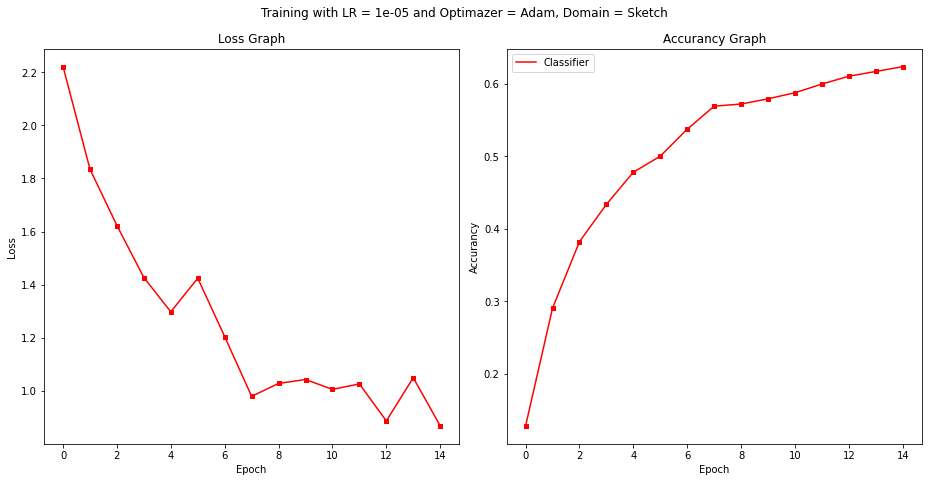

Classifier: Min Loss: 0.867706, Max Acc: 0.623353
****** Test ******
Test Accuracy: 0.24179180453041485
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.647
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 0.9118
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 0.8111
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 0.8064
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 0.8048
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 0.6618
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 0.6806
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 0.6938
Starting epo

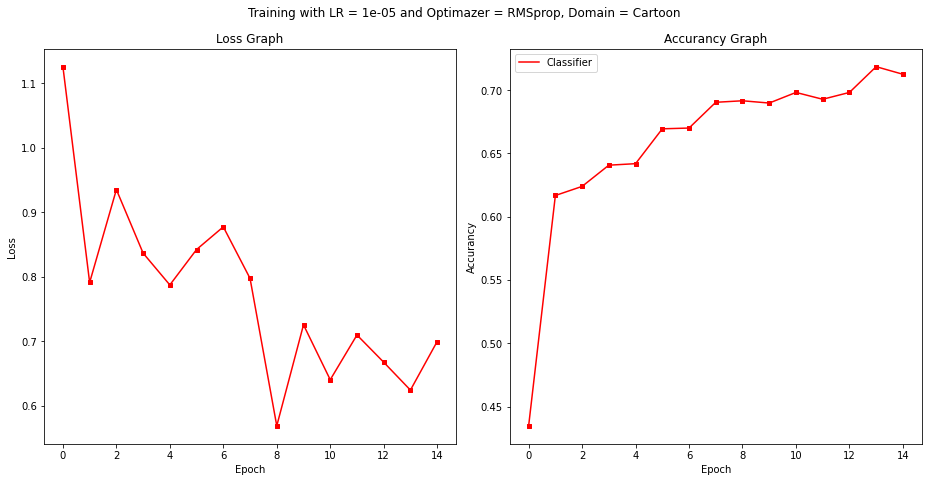

Classifier: Min Loss: 0.568940, Max Acc: 0.718563
****** Test ******
Test Accuracy: 0.17918088737201365
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.931
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 0.9423
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 0.8516
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 0.6909
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 0.7454
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 0.6777
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 0.6778
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 0.5783
Starting epoc

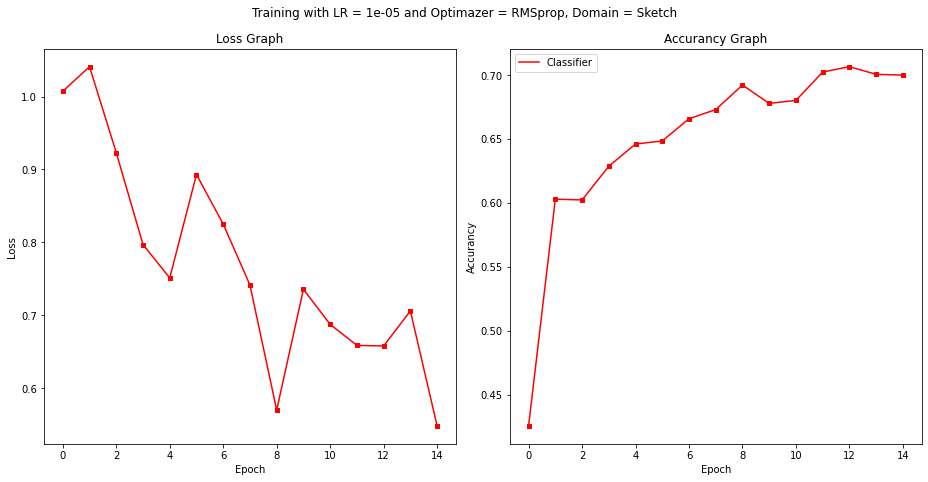

Classifier: Min Loss: 0.548423, Max Acc: 0.706587
****** Test ******
Test Accuracy: 0.21455841180962076
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD, Domain = Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 2.428
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 2.159
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 2.228
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 1.84
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.828
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 1.701
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 1.718
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 1.566
Starting epoch 13/15, LR

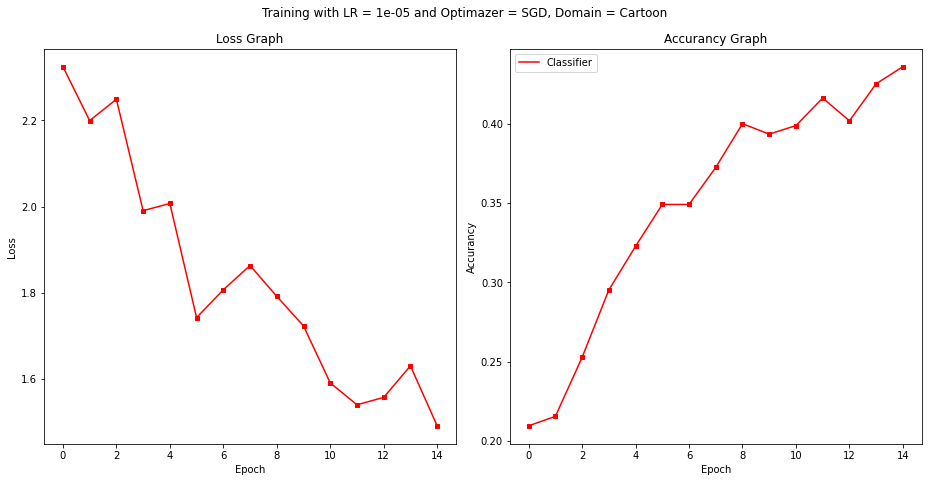

Classifier: Min Loss: 1.491225, Max Acc: 0.435928
****** Test ******
Test Accuracy: 0.14377133105802048
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD, Domain = Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [1e-05]
Step 0, Loss Classifier: 3.043
Starting epoch 2/15, LR = [1e-05]
Step 10, Loss Classifier: 2.675
Starting epoch 3/15, LR = [1e-05]
Starting epoch 4/15, LR = [1e-05]
Step 20, Loss Classifier: 2.235
Starting epoch 5/15, LR = [1e-05]
Starting epoch 6/15, LR = [1e-05]
Step 30, Loss Classifier: 2.221
Starting epoch 7/15, LR = [1e-05]
Step 40, Loss Classifier: 1.819
Starting epoch 8/15, LR = [1e-05]
Starting epoch 9/15, LR = [1e-05]
Step 50, Loss Classifier: 1.732
Starting epoch 10/15, LR = [1e-05]
Starting epoch 11/15, LR = [1e-05]
Step 60, Loss Classifier: 1.542
Starting epoch 12/15, LR = [1e-05]
Step 70, Loss Classifier: 1.592
Starting epoch 13/15, LR

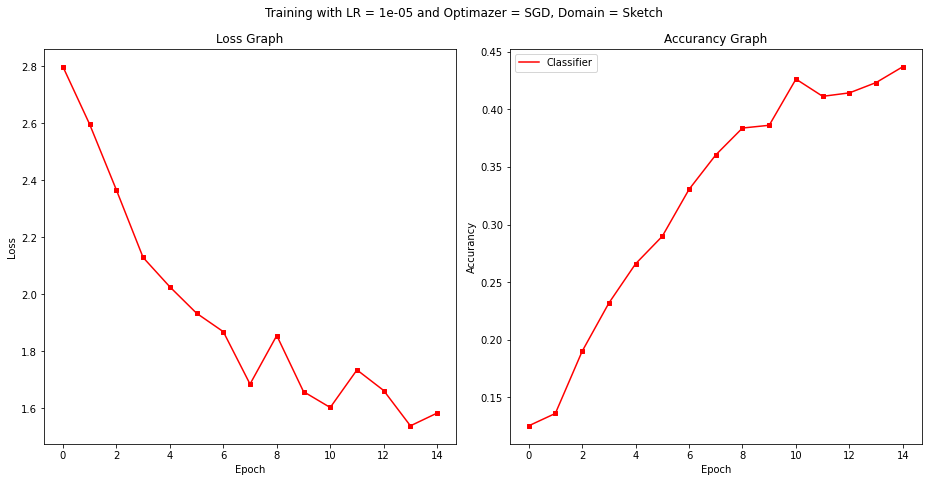

Classifier: Min Loss: 1.538647, Max Acc: 0.437126
****** Test ******
Test Accuracy: 0.11326037159582591
---  --- ---  ---



In [0]:
NUM_EPOCHS = 15
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

val = [val_cart_dataloader, val_sket_dataloader]
val_acc = {}

scores_noAdap = {}
for lr in lr_values:
  for op in optimazers:
    temp_acc = []
    for i,v in enumerate(val):
      domain = 'Cartoon' if i==0 else 'Sketch'
      meta = 'Training with LR = {}, Optimazer = {}, Domain = {}'.format(lr,op, domain)
      print('---  {}  ---'.format(meta))

      net = InitializeNet()
      print()

      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'noAdap LR={}, op={}, dom={}'.format(lr,op,domain)
      losses, accuracies = Training(net,meta=meta_t,target_loader=v)
      PlotAccuracyLoss(losses,accuracies,meta)

      scores_noAdap[(lr,op)] = (losses, accuracies)

      print('****** Test ******')
      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      temp_acc.append(Test(best_net,v))

      print('---  --- ---  ---')
      print()
    val_acc[(lr,op)] = temp_acc


In [0]:
val_acc

{(1e-05, 'Adam'): [0.181740614334471, 0.24179180453041485],
 (1e-05, 'RMSprop'): [0.17918088737201365, 0.21455841180962076],
 (1e-05, 'SGD'): [0.14377133105802048, 0.11326037159582591],
 (0.001, 'Adam'): [0.1727815699658703, 0.020361415118350726],
 (0.001, 'RMSprop'): [0.1727815699658703, 0.04072283023670145],
 (0.001, 'SGD'): [0.1719283276450512, 0.1616187325019089],
 (0.01, 'Adam'): [0.17320819112627986, 0.021634003563247645],
 (0.01, 'RMSprop'): [0.19411262798634812, 0.04072283023670145],
 (0.01, 'SGD'): [0.22994880546075086, 0.24713667599898193]}

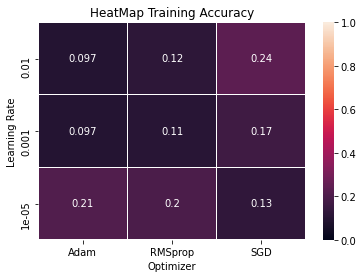

In [0]:
val_acc_mean = dict(map(lambda item: (item[0], np.mean(item[1])), val_acc.items()))
SketchHeatMap(val_acc_mean,performMax=False)

In [0]:
best_lr = 0.01
best_op = 'SGD'

111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.373
Starting epoch 2/30, LR = [0.01]
Step 10, Loss Classifier: 0.933
Starting epoch 3/30, LR = [0.01]
Starting epoch 4/30, LR = [0.01]
Step 20, Loss Classifier: 1.056
Starting epoch 5/30, LR = [0.01]
Starting epoch 6/30, LR = [0.01]
Step 30, Loss Classifier: 0.7904
Starting epoch 7/30, LR = [0.01]
Step 40, Loss Classifier: 0.7861
Starting epoch 8/30, LR = [0.01]
Starting epoch 9/30, LR = [0.01]
Step 50, Loss Classifier: 0.8149
Starting epoch 10/30, LR = [0.01]
Starting epoch 11/30, LR = [0.01]
Step 60, Loss Classifier: 0.7467
Starting epoch 12/30, LR = [0.01]
Step 70, Loss Classifier: 0.7822
Starting epoch 13/30, LR = [0.01]
Starting epoch 14/30, LR = [0.01]
Step 80, Loss Classifier: 0.7213
Starting epoch 15/30, LR = [0.01]
Starting epoch 16/30, LR = [0.01]
Step 90, Loss Classifier: 0.7154
Starting epoch 17/30, LR = [0.01]
Step 100, Loss Classifier: 0.6016
Starting epoch 18/30, LR = [0.01]
Starting epoch 19/30, LR = [0.01]
Step 110, Loss Classifier: 0.6864
St

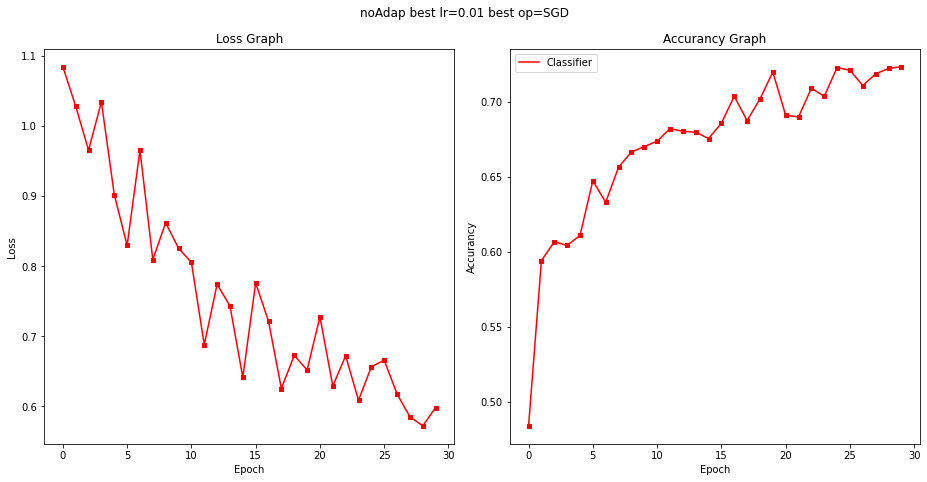

Classifier: Min Loss: 0.571843, Max Acc: 0.723353

Test Accuracy: 0.31884765625


In [0]:
NUM_EPOCHS = 30

net = InitializeNet()

criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = net.parameters() 

if(best_op == 'Adam'):
  optimizer = optim.Adam(parameters_to_optimize, lr=best_lr, weight_decay=WEIGHT_DECAY)
elif(best_op == 'RMSprop'):
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
else:
  optimizer = optim.SGD(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

meta_t = 'noAdap best lr={} best op={}'.format(best_lr,best_op)
losses, accuracies = Training(net,meta=meta_t)

print()
meta = 'Training without Adaptation'
PlotAccuracyLoss(losses,accuracies,meta_t)

print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
_ = Test(best_net,target_dataloader)

## Adaptation

---  Training with Alpha = 0.1 and Optimazer = Adam Cartoon  ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.544, Domain Classifier: 2.921, Domain Classifier(Target): 1.985
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 2.653, Domain Classifier: 31.96, Domain Classifier(Target): 4.701
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 3.542, Domain Classifier: 1.788e-07, Domain Classifier(Target): 22.69
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 2.0, Domain Classifier: 17.61, Domain Classifier(Target): 0.5615
Starting epoch 7/15, LR = [0.001]
Step 40, Loss Classifier: 1.933, Domain Classifier: 1.16, Domain Classifier(Target): 2.973
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Step 50, Loss Classifier: 1.96, Domain Classifier: 0.4994, Domain Classifier(Target): 2.678
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Step 60, Loss Classifier: 2.026, Domain Classifier: 0.9296, Domain Classifier(Target): 0.5874
Starting ep

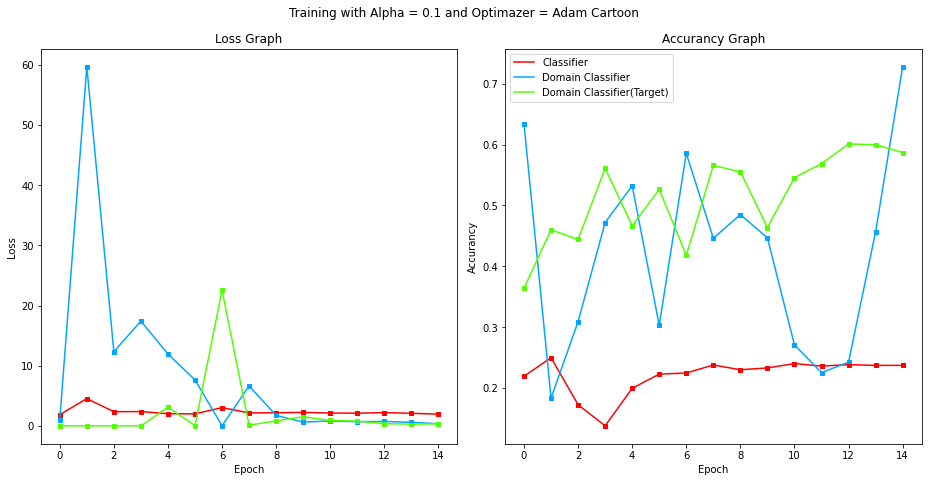

Classifier: Min Loss: 1.848031, Max Acc: 0.249701
Domain Classifier: Min Loss: 0.011971, Max Acc: 0.728144
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.601109
****** Test ******
Test Accuracy: 0.1582764505119454
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = Adam Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.512, Domain Classifier: 2.34, Domain Classifier(Target): 1.86
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 2.907, Domain Classifier: 0.3359, Domain Classifier(Target): 1.627
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 2.972, Domain Classifier: 0.1622, Domain Classifier(Target): 1.788e-07
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.976, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starti

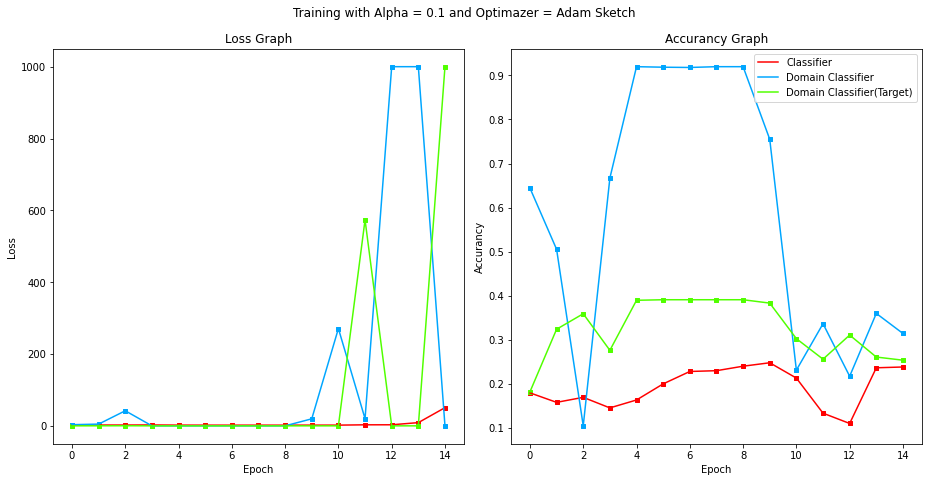

Classifier: Min Loss: 1.903763, Max Acc: 0.247904
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = RMSprop Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.984, Domain Classifier: 2.499, Domain Classifier(Target): 2.232
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 4.953e+07, Domain Classifier(Target): 0.0
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target): 4.587e+04
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
S

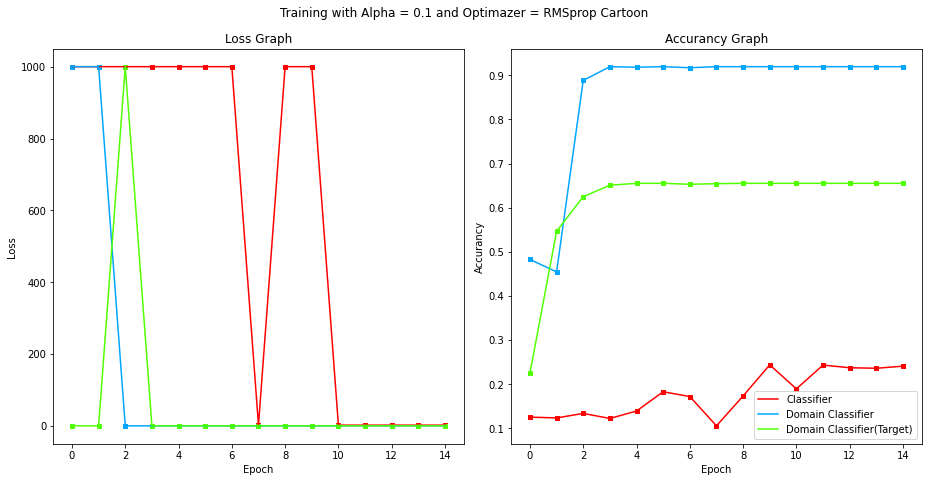

Classifier: Min Loss: 1.896890, Max Acc: 0.243713
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.1727815699658703
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = RMSprop Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.524, Domain Classifier: 2.051, Domain Classifier(Target): 2.846
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 5.283e+08, Domain Classifier(Target): 0.0
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03, Domain Classifier: 6.125e+07, Domain Classifier(Target): 0.0
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1e+03, Domain Classifier: 3.644e+07, Domain Classifier(Target): 4

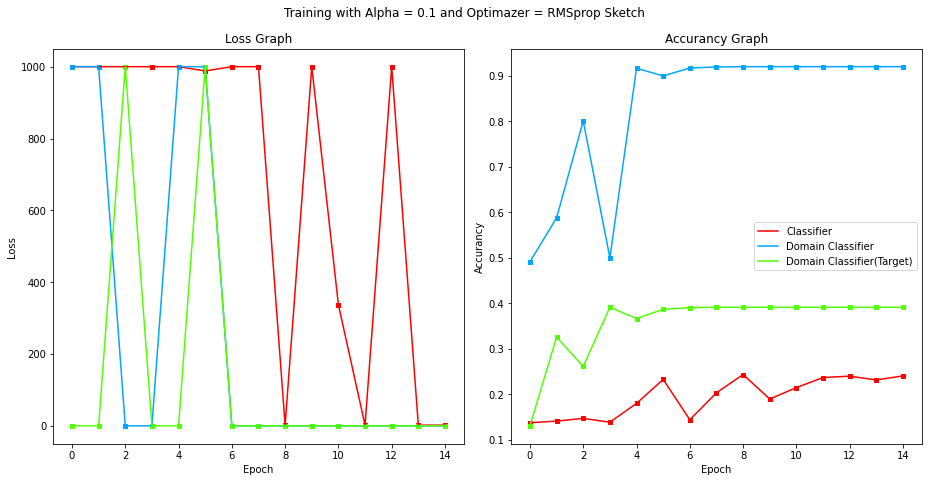

Classifier: Min Loss: 1.884545, Max Acc: 0.243114
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.15474675489946552
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = SGD Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.904, Domain Classifier: 3.127, Domain Classifier(Target): 2.599
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 0.9357, Domain Classifier: 0.03567, Domain Classifier(Target): 0.009228
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.7917, Domain Classifier: 0.003279, Domain Classifier(Target): 0.003727
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.8271, Domain Classifier: 0.1022, Domain Classifier(Targe

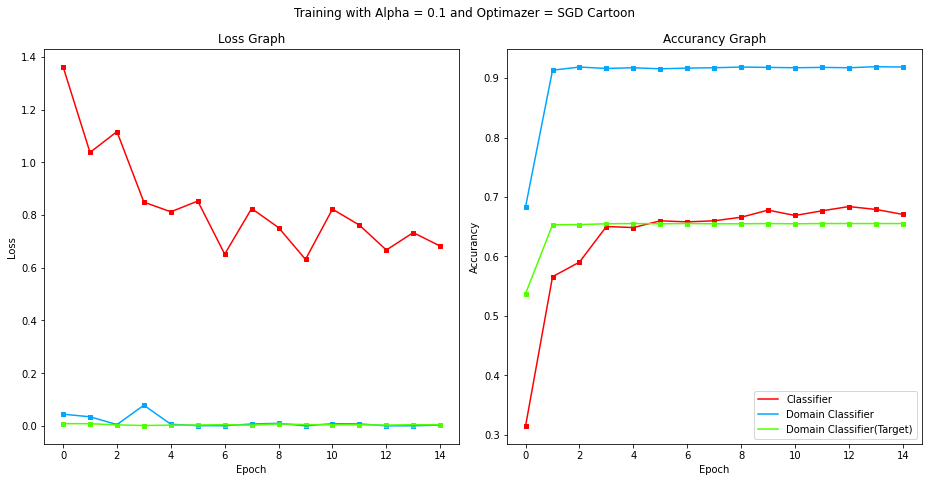

Classifier: Min Loss: 0.631710, Max Acc: 0.683832
Domain Classifier: Min Loss: 0.000012, Max Acc: 0.919162
Domain Classifier(Target): Min Loss: 0.001221, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.19197952218430034
---  --- ---  ---

---  Training with Alpha = 0.1 and Optimazer = SGD Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.91, Domain Classifier: 3.542, Domain Classifier(Target): 1.632
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.122, Domain Classifier: 0.001948, Domain Classifier(Target): 4.731e-06
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9098, Domain Classifier: 0.005148, Domain Classifier(Target): 2.895e-06
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.7705, Domain Classifier: 0.000257, Domain Classifier(Tar

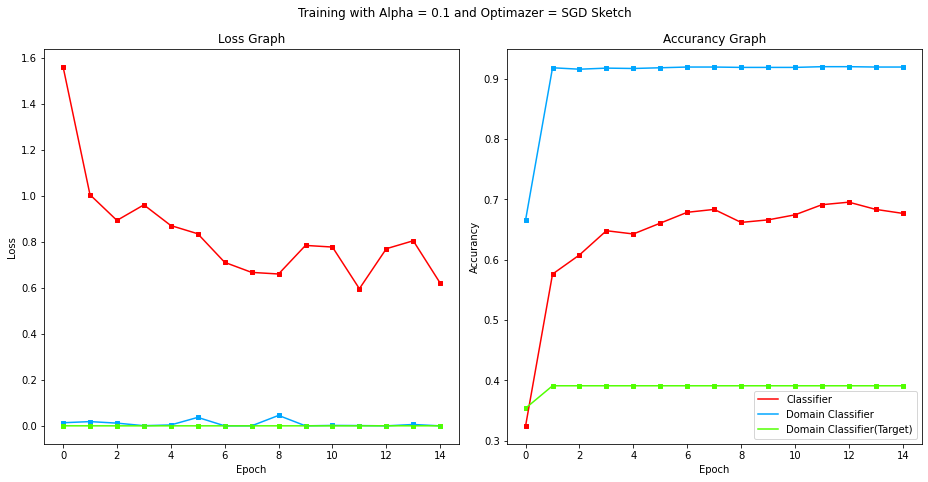

Classifier: Min Loss: 0.596116, Max Acc: 0.695210
Domain Classifier: Min Loss: 0.000006, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000004, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.20565029269534232
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = Adam Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.316, Domain Classifier: 2.651, Domain Classifier(Target): 2.515
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.597, Domain Classifier: 0.7429, Domain Classifier(Target): 0.1305
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.918, Domain Classifier: 0.787, Domain Classifier(Target): 0.7101
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.864, Domain Classifier: 0.7535, Domain Classifier(Target): 0.612

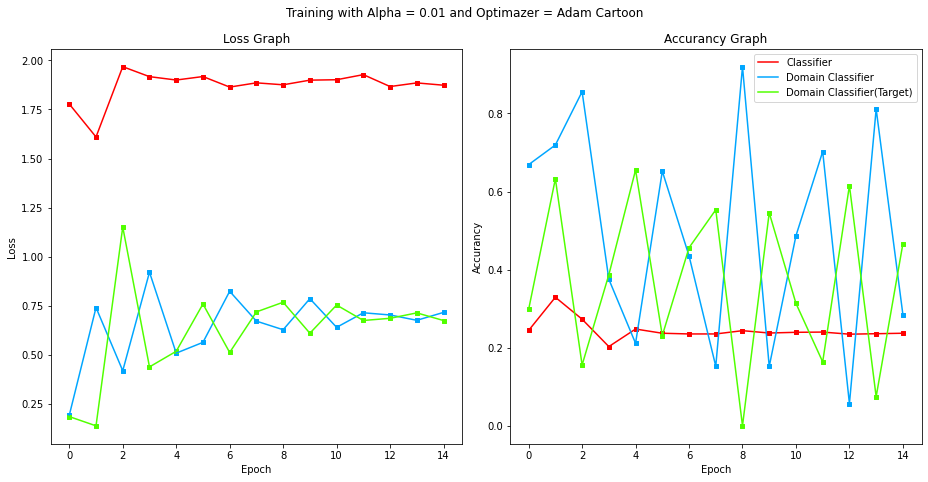

Classifier: Min Loss: 1.609854, Max Acc: 0.329341
Domain Classifier: Min Loss: 0.190844, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.136479, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.1318259385665529
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = Adam Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.408, Domain Classifier: 3.185, Domain Classifier(Target): 2.043
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 2.155, Domain Classifier: 0.06845, Domain Classifier(Target): 1.349
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.918, Domain Classifier: 0.8175, Domain Classifier(Target): 0.576
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.888, Domain Classifier: 0.6272, Domain Classifier(Target): 0.7621


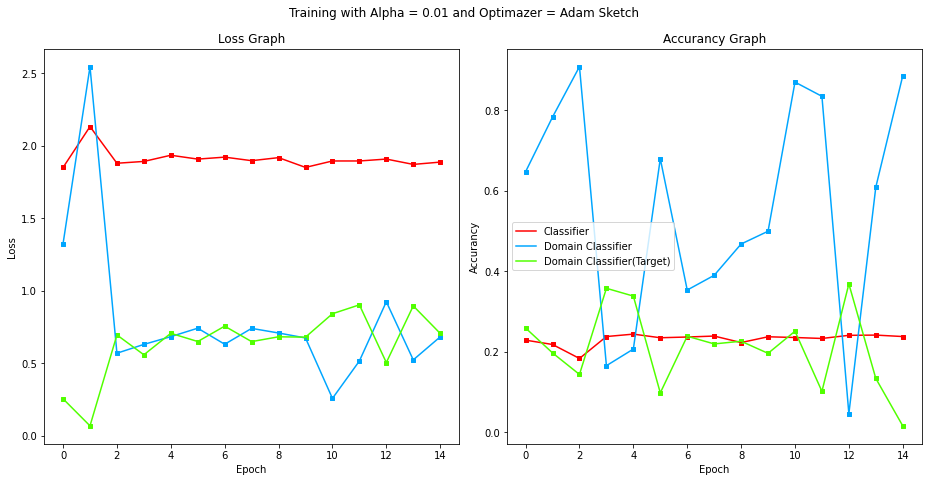

Classifier: Min Loss: 1.851622, Max Acc: 0.243713
Domain Classifier: Min Loss: 0.258377, Max Acc: 0.908383
Domain Classifier(Target): Min Loss: 0.069045, Max Acc: 0.368542
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = RMSprop Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.813, Domain Classifier: 2.779, Domain Classifier(Target): 2.425
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 2.726e+06, Domain Classifier(Target): 3.735e+07
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03, Domain Classifier: 1.107e+07, Domain Classifier(Target): 0.0
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 2.014, Domain Classifier: 0.0, Domain Classifier(Target)

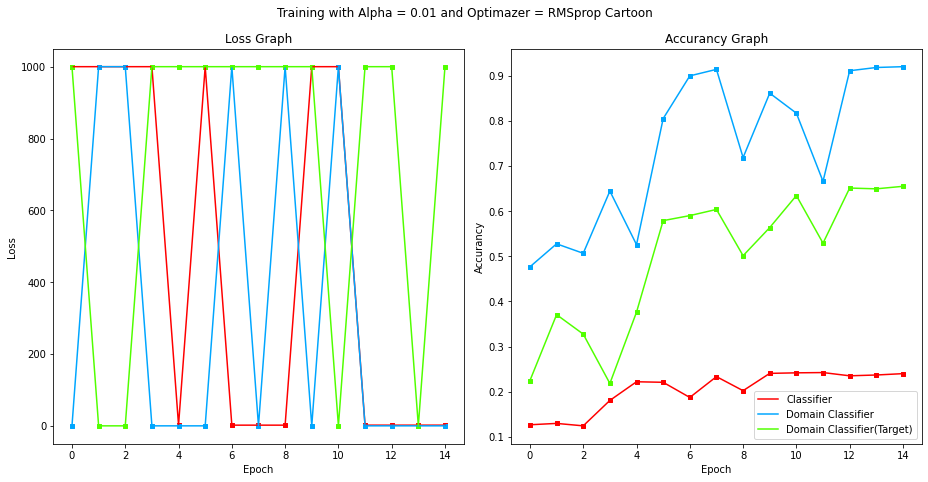

Classifier: Min Loss: 1.865502, Max Acc: 0.242515
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.654863
****** Test ******
Test Accuracy: 0.16424914675767918
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = RMSprop Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.77, Domain Classifier: 3.027, Domain Classifier(Target): 1.779
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 3.839e+05, Domain Classifier(Target): 3.843e+04
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target): 7.465e+06
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 3.143, Domain Classifier: 1.606e+07, Domain Classifier(Tar

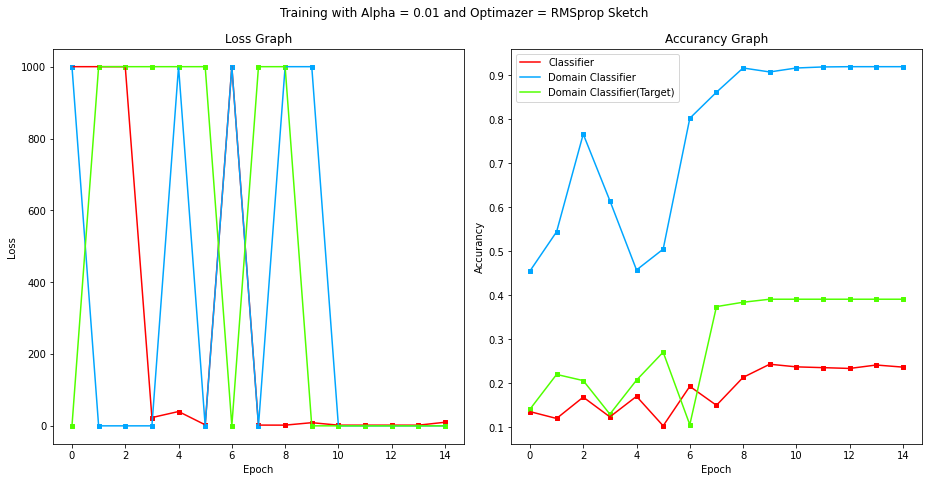

Classifier: Min Loss: 1.862852, Max Acc: 0.243114
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = SGD Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.885, Domain Classifier: 3.179, Domain Classifier(Target): 1.697
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.096, Domain Classifier: 0.01077, Domain Classifier(Target): 0.01275
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9526, Domain Classifier: 0.01654, Domain Classifier(Target): 0.00283
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.8083, Domain Classifier: 0.002219, Domain Classifier(Target

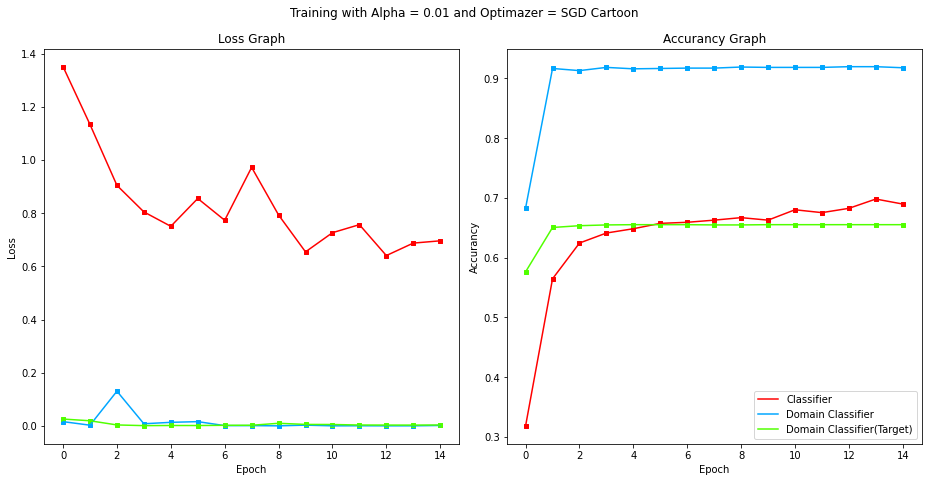

Classifier: Min Loss: 0.640545, Max Acc: 0.698204
Domain Classifier: Min Loss: 0.000024, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000820, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.28967576791808874
---  --- ---  ---

---  Training with Alpha = 0.01 and Optimazer = SGD Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.452, Domain Classifier: 2.727, Domain Classifier(Target): 2.79
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.07, Domain Classifier: 0.06606, Domain Classifier(Target): 2.57e-07
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9855, Domain Classifier: 0.005135, Domain Classifier(Target): 1.49e-08
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.9784, Domain Classifier: 0.03266, Domain Classifier(Target)

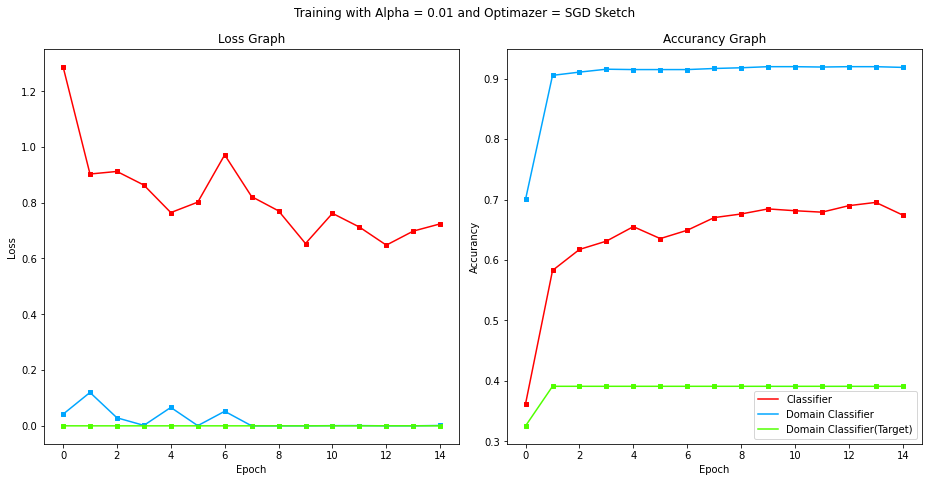

Classifier: Min Loss: 0.647872, Max Acc: 0.695210
Domain Classifier: Min Loss: 0.000008, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.2575719012471367
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = Adam Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.79, Domain Classifier: 2.837, Domain Classifier(Target): 2.43
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 2.104, Domain Classifier: 0.009626, Domain Classifier(Target): 0.9543
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.645, Domain Classifier: 0.6658, Domain Classifier(Target): 0.3881
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.555, Domain Classifier: 0.3217, Domain Classifier(Target): 0.37

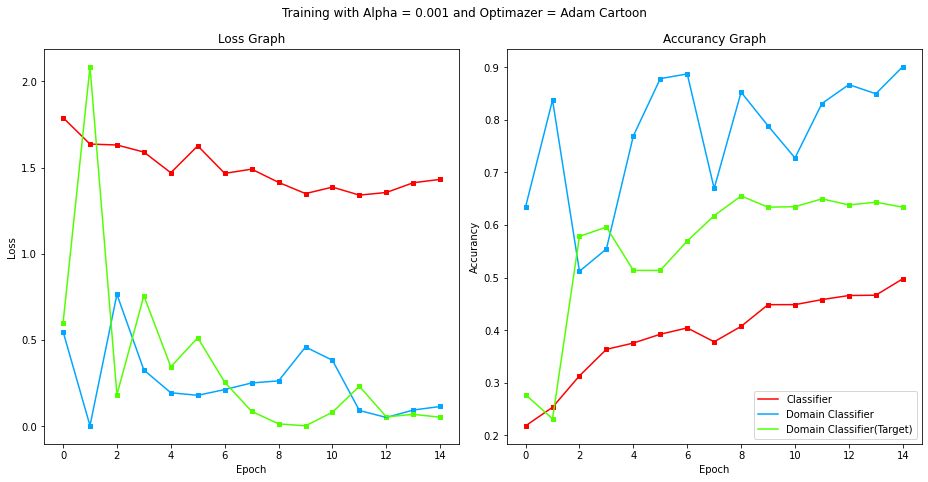

Classifier: Min Loss: 1.340281, Max Acc: 0.497605
Domain Classifier: Min Loss: 0.003941, Max Acc: 0.901198
Domain Classifier(Target): Min Loss: 0.003045, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.06569965870307168
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = Adam Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 3.068, Domain Classifier: 2.86, Domain Classifier(Target): 2.724
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.659, Domain Classifier: 0.2961, Domain Classifier(Target): 0.1254
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1.6, Domain Classifier: 0.5532, Domain Classifier(Target): 0.5906
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1.505, Domain Classifier: 0.3312, Domain Classifier(Target): 0.2432


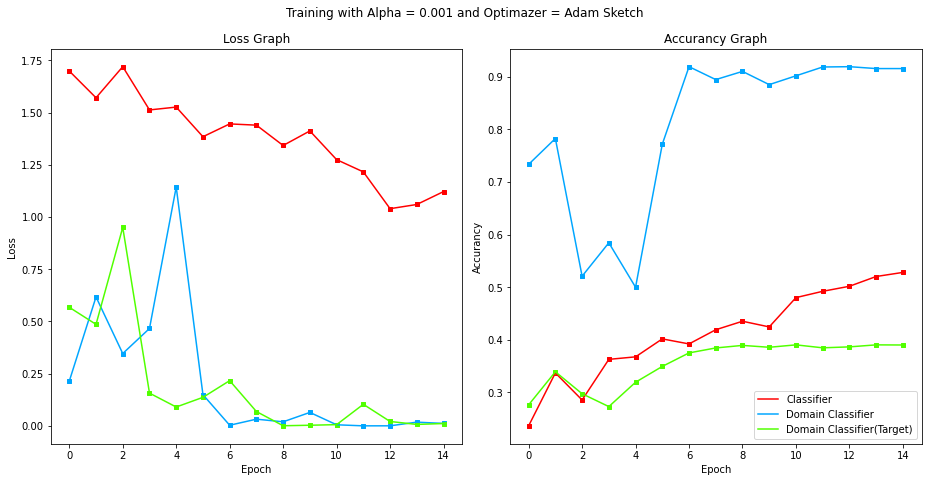

Classifier: Min Loss: 1.040215, Max Acc: 0.528144
Domain Classifier: Min Loss: 0.000088, Max Acc: 0.919162
Domain Classifier(Target): Min Loss: 0.000530, Max Acc: 0.390430
****** Test ******
Test Accuracy: 0.1980147620259608
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = RMSprop Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.683, Domain Classifier: 2.054, Domain Classifier(Target): 2.808
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 770.7, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 106.3, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epo

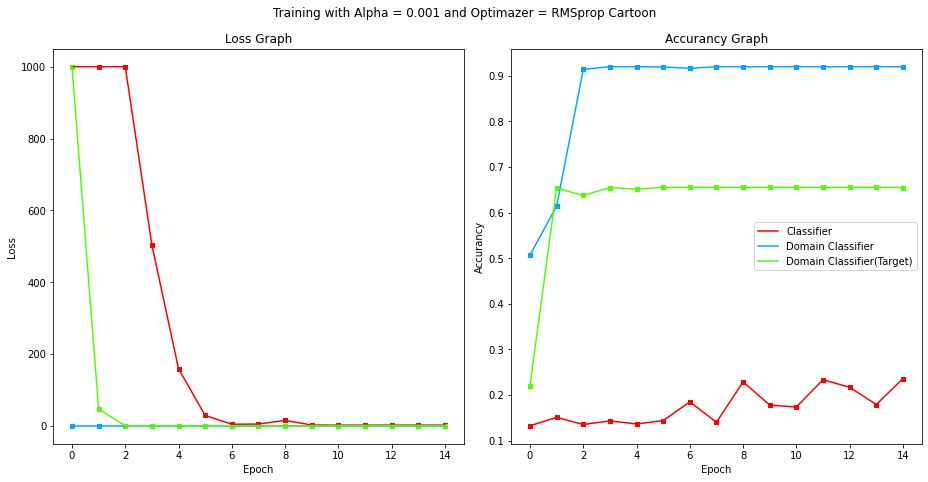

Classifier: Min Loss: 1.961411, Max Acc: 0.235928
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.1659556313993174
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = RMSprop Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.611, Domain Classifier: 2.373, Domain Classifier(Target): 2.416
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target): 1.264e+07
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 1e+03, Domain Classifier: 9.222e+05, Domain Classifier(Target): 1.168e+06
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 1e+03, Domain Classifier: 0.0, Domain Classifier(Target):

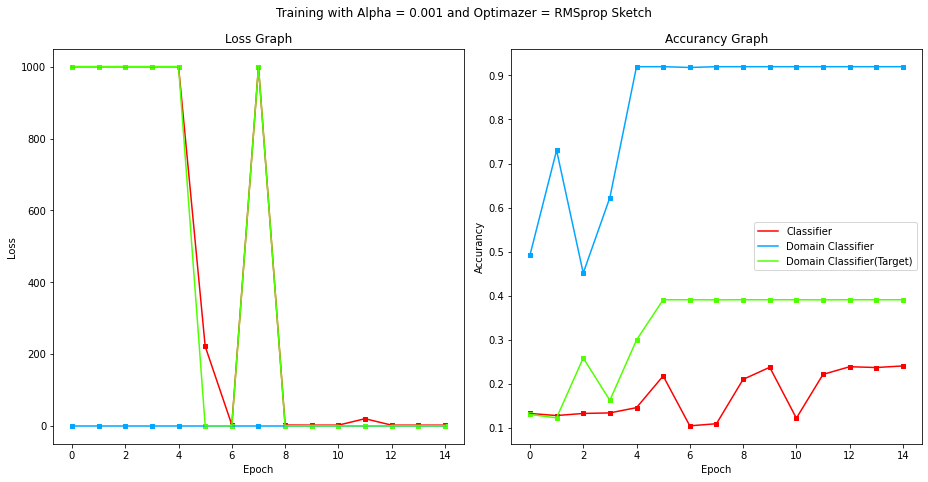

Classifier: Min Loss: 1.883441, Max Acc: 0.240719
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.04072283023670145
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = SGD Cartoon  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.844, Domain Classifier: 3.103, Domain Classifier(Target): 2.015
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.136, Domain Classifier: 0.001283, Domain Classifier(Target): 0.006335
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9304, Domain Classifier: 0.000379, Domain Classifier(Target): 0.00244
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.7415, Domain Classifier: 0.01274, Domain Classifier(Tar

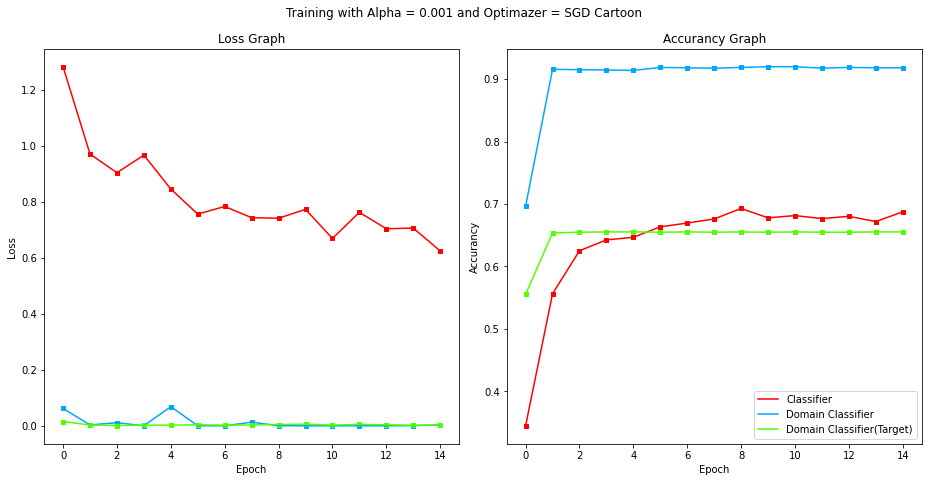

Classifier: Min Loss: 0.624729, Max Acc: 0.692814
Domain Classifier: Min Loss: 0.000018, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.001105, Max Acc: 0.655290
****** Test ******
Test Accuracy: 0.18430034129692832
---  --- ---  ---

---  Training with Alpha = 0.001 and Optimazer = SGD Sketch  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/15, LR = [0.001]
Step 0, Loss Classifier: 2.538, Domain Classifier: 3.246, Domain Classifier(Target): 2.787
Starting epoch 2/15, LR = [0.001]
Step 10, Loss Classifier: 1.199, Domain Classifier: 0.0004753, Domain Classifier(Target): 4.845e-05
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Step 20, Loss Classifier: 0.9802, Domain Classifier: 0.02642, Domain Classifier(Target): 1.162e-05
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Step 30, Loss Classifier: 0.795, Domain Classifier: 0.00935, Domain Classifier(Ta

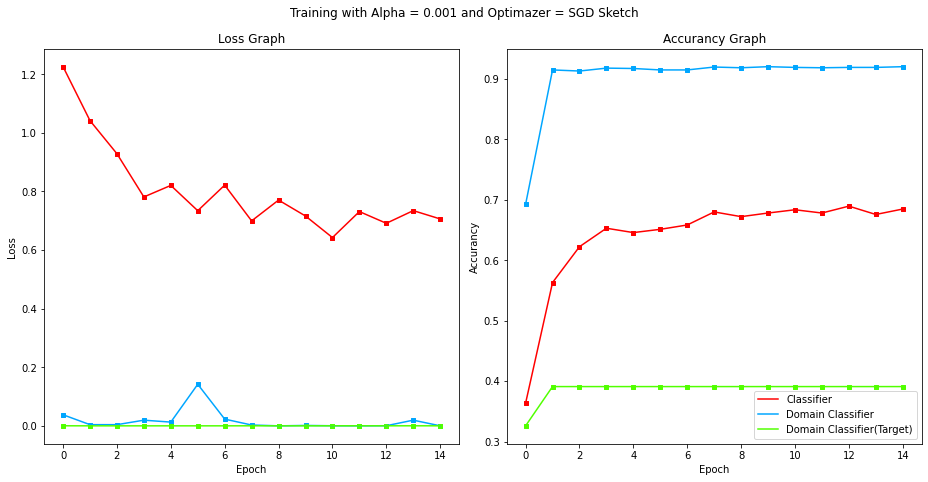

Classifier: Min Loss: 0.642572, Max Acc: 0.689222
Domain Classifier: Min Loss: 0.000031, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.390939
****** Test ******
Test Accuracy: 0.22015780096716722
---  --- ---  ---



In [0]:
NUM_EPOCHS = 15
alpha_values = [0.1, 0.01, 0.001]
optimazers = ['Adam','RMSprop','SGD']

val = [val_cart_dataloader, val_sket_dataloader]
val_acc = {}

scores_Adap = {}
for al in alpha_values:
  for op in optimazers:
    temp_acc = []
    for i,v in enumerate(val):
      domain = 'Cartoon' if i==0 else 'Sketch'
      meta = 'Training with Alpha = {}, Optimazer = {}, Domain = {}'.format(al,op,domain)
      print('---  {}  ---'.format(meta))

      net = InitializeNet(alpha=al)
      print()

      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'Adap al={}, op={}, dom={}'.format(al,op,domain)
      
      losses, accuracies = Training(net,True,meta=meta_t,target_loader=v)
      PlotAccuracyLoss(losses,accuracies,meta)

      scores_Adap[(al,op)] = (losses, accuracies)

      print('****** Test ******')
      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      temp_acc.append(Test(best_net,v))

      print('---  --- ---  ---')
      print()
    val_acc[(al,op)] = temp_acc


In [0]:
val_acc

{(0.001, 'Adam'): [0.06569965870307168, 0.1980147620259608],
 (0.001, 'RMSprop'): [0.1659556313993174, 0.04072283023670145],
 (0.001, 'SGD'): [0.18430034129692832, 0.22015780096716722],
 (0.01, 'Adam'): [0.1318259385665529, 0.04072283023670145],
 (0.01, 'RMSprop'): [0.16424914675767918, 0.04072283023670145],
 (0.01, 'SGD'): [0.28967576791808874, 0.2575719012471367],
 (0.1, 'Adam'): [0.1582764505119454, 0.04072283023670145],
 (0.1, 'RMSprop'): [0.1727815699658703, 0.15474675489946552],
 (0.1, 'SGD'): [0.19197952218430034, 0.20565029269534232]}

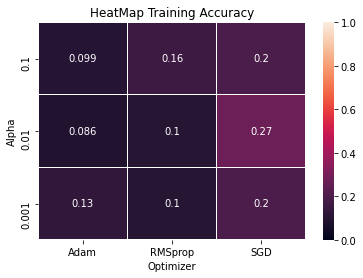

In [0]:
val_acc_mean = dict(map(lambda item: (item[0], np.mean(item[1])), val_acc.items()))
SketchHeatMap(val_acc_mean,performMax=False,Lr=False)

In [0]:
best_al = 0.01
best_op = 'SGD'

111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.
Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 3.322, Domain Classifier: 3.046, Domain Classifier(Target): 2.361
Starting epoch 2/30, LR = [0.001]
Step 10, Loss Classifier: 1.002, Domain Classifier: 0.0811, Domain Classifier(Target): 0.005005
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss Classifier: 0.95, Domain Classifier: 0.01926, Domain Classifier(Target): 0.008104
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss Classifier: 0.7966, Domain Classifier: 0.01181, Domain Classifier(Target): 0.01166
Starting epoch 7/30, LR = [0.001]
Step 40, Loss Classifier: 0.7756, Domain Classifier: 0.01317, Domain Classifier(Target): 0.006926
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss Classifier: 0.7492, Domain Classifier: 0.0038, Domain Classifier(Target): 0.007172
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss Classifier: 0.7235, Domain Classifier: 0.02224, Domain Classifier(Tar

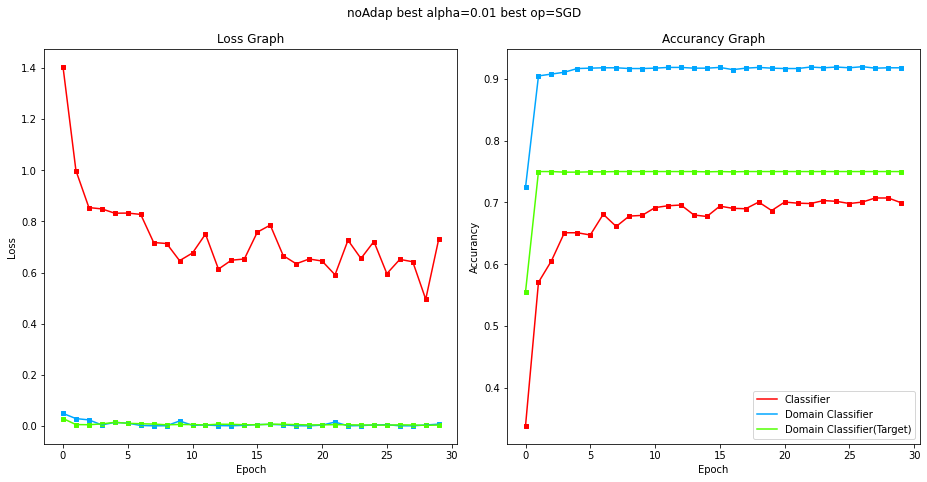

Classifier: Min Loss: 0.495340, Max Acc: 0.707186
Domain Classifier: Min Loss: 0.000367, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.002371, Max Acc: 0.750000

Test Accuracy: 0.37109375


In [0]:
NUM_EPOCHS = 30

net = InitializeNet(alpha=best_al)

criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = net.parameters() 

if(best_op == 'Adam'):
  optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
elif(best_op == 'RMSprop'):
  optimizer = optim.RMSprop(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
else:
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

meta_t = 'Adap best alpha={} best op={}'.format(best_al,best_op)
losses, accuracies = Training(net,True,meta=meta_t)

print()
meta = 'Training with Adaptation'
PlotAccuracyLoss(losses,accuracies,meta_t)

print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
_ = Test(best_net,target_dataloader)

In [0]:
#Best pairs found in the no adaptation part
best_op = 'SGD'
best_lr = 0.01
best_al = 0.01

111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.324, Domain Classifier: 2.473, Domain Classifier(Target): 2.417
Starting epoch 2/30, LR = [0.01]
Step 10, Loss Classifier: 1.153, Domain Classifier: 0.009414, Domain Classifier(Target): 0.05515
Starting epoch 3/30, LR = [0.01]
Starting epoch 4/30, LR = [0.01]
Step 20, Loss Classifier: 0.7813, Domain Classifier: 0.07497, Domain Classifier(Target): 0.0213
Starting epoch 5/30, LR = [0.01]
Starting epoch 6/30, LR = [0.01]
Step 30, Loss Classifier: 0.8765, Domain Classifier: 0.01367, Domain Classifier(Target): 0.02931
Starting epoch 7/30, LR = [0.01]
Step 40, Loss Classifier: 0.7807, Domain Classifier: 0.004416, Domain Classifier(Target): 0.03292
Starting epoch 8/30, LR = [0.01]
Starting epoch 9/30, LR = [0.01]
Step 50, Loss Classifier: 0.7818, Domain Classifier: 0.02382, Domain Classifier(Target): 0.002514
Starting epoch 10/30, LR = [0.01]
Starting epoch 11/30, LR = [0.01]
Step 60, Loss Classifier: 0.7863, Domain Classifier: 0.005218, Domain Classifier(Target): 0

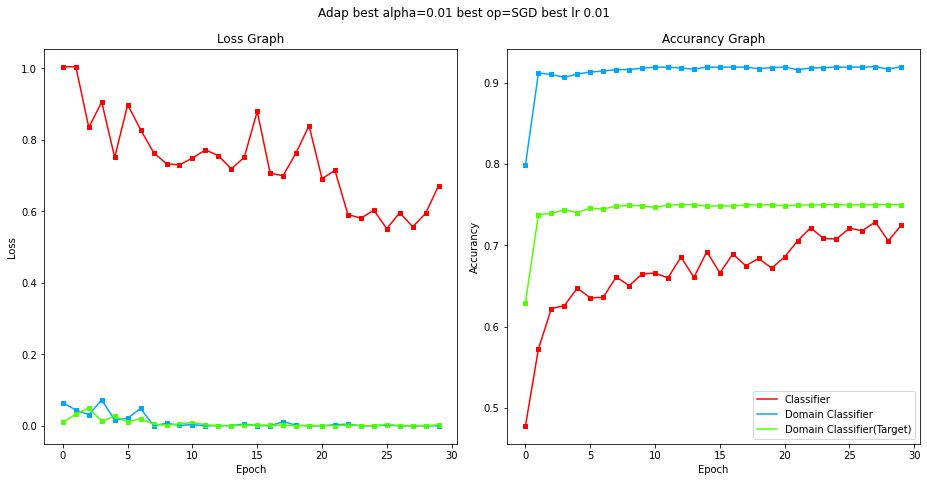

Classifier: Min Loss: 0.551101, Max Acc: 0.728743
Domain Classifier: Min Loss: 0.000009, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000139, Max Acc: 0.750000

Test Accuracy: 0.34326171875


In [0]:
NUM_EPOCHS = 30

net = InitializeNet(alpha=best_al)

criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = net.parameters() 

if(best_op == 'Adam'):
  optimizer = optim.Adam(parameters_to_optimize, lr=best_lr, weight_decay=WEIGHT_DECAY)
elif(best_op == 'RMSprop'):
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
else:
  optimizer = optim.SGD(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

meta_t = 'Adap best alpha={} best op={} best lr {}'.format(best_al,best_op,best_lr)
losses, accuracies = Training(net,True,meta=meta_t)

print()
meta = 'Training with Adaptation'
PlotAccuracyLoss(losses,accuracies,meta_t)

print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
_ = Test(best_net,target_dataloader)